Victor Mikhaylov, vmikhayl@ias.edu<br>Institute for Advanced Study, 2021-2022

In [1]:
import os
import stat
import time
import numpy as np
import pickle
import re
import itertools
import pandas as pd

from scipy import cluster
from scipy.spatial.distance import squareform #for distance matrix conversion

from matplotlib import pyplot as plt

cwd=os.getcwd()

import importlib

if 1:
    from tfold.utils import utils,seq_tools,pdb_tools
    from tfold.structure_database import process_pdbs 
    from tfold.modeling import template_tools    

if 0:
    importlib.reload(utils)
    importlib.reload(seq_tools)
    importlib.reload(pdb_tools)
    importlib.reload(process_pdbs)
    importlib.reload(template_tools)

MHC loading from MHC.pckl. To update the pickle file, set use_pickle to False
loaded 26122 MHC sequences in  1.8 s
TCR loading from TCR.pckl. To update the pickle file, set use_pickle to False
loaded 2835 TCR sequences in  0.1 s


# search PDB

In [ ]:
#pdb_seqres.txt downloaded on 7/5/2022; previous version was from Nov 2021
#path to pdb database is specified in tfold_config.py

In [5]:
#choose MSAs, make search script

output_dir=cwd+'/data/experimental_structures/pdb_search'
os.makedirs(output_dir,exist_ok=True)
sh_path='./scripts/search_pdb.sh'
search_script_path='/data/vmikhayl/alphafold-multimer/alphafold/tfold_msa_tools.py'
msa_list=[(cwd+'/data/msas/MHC/I_A_0/uniref90_hits.sto', 'MHC_I_A'),
          (cwd+'/data/msas/MHC/II_A_0/uniref90_hits.sto','MHC_II_A'),
          (cwd+'/data/msas/MHC/II_B_0/uniref90_hits.sto','MHC_II_B'),
          (cwd+'/data/msas/TRV/TRAV/uniref90_hits.sto','TRAV'),
          (cwd+'/data/msas/TRV/TRBV/uniref90_hits.sto','TRBV')]
lines=[]
lines.append('#!/bin/bash')
lines.append('')
for msa in msa_list:
    c_output_dir=output_dir+'/'+msa[1]
    lines.append(f'python {search_script_path} {msa[0]} pdb {c_output_dir}')
with open(sh_path,'w') as f:
    f.write('\n'.join(lines))
os.chmod(sh_path, stat.S_IRWXU | stat.S_IXGRP | stat.S_IXOTH) 

In [6]:
#load results
output_dir=cwd+'/data/experimental_structures/pdb_search'
result_descriptors={}
for x in os.listdir(output_dir):
    with open(output_dir+f'/{x}/pdb_hits.a3m') as f:
        a3m_str=f.read()
    for line in a3m_str.split('\n'):
        if line.startswith('>'):
            result_descriptors[line[1:5]]=line
print(len(result_descriptors))    

#drop antibodies
#result_descriptors_cut={}
#for k,v in result_descriptors.items():
#    x=v.lower()
#    if not (('body' in x)) or ('fab' in x)): #'fab' drops at least one useful structure
#        result_descriptors_cut[k]=v
#print(len(result_descriptors_cut)) 

#seqres from 11/2021: 8418
#seqres from 07/2022: 9178

9178


In [7]:
#compare to pdbs from databases
structures_dir='/data/vmikhayl/TCR_pMHC_prediction_2.1/data/experimental_structures/pdb'
pdb_list=os.listdir(structures_dir)
pdb_old=set([x.split('.')[0] for x in pdb_list])
pdb_new=set(result_descriptors.keys())
print('old:',len(pdb_old))
print('new:',len(pdb_new))
print('missing:',len(pdb_old-pdb_new))
print('added:',len(pdb_new-pdb_old))
#just MHC   : old 1350, new 1783, missing 136, added  569
#TRV and MHC:                     missing   0, added 7068 (mostly Ab, probably)

#seqres from 11/2021:
#old: 1350, new: 8418, missing: 0, added: 7068
#seqres from 07/2022:
#old: 1350, new: 9178, missing: 0, added: 7828

old: 1350
new: 9178
missing: 0
added: 7828


In [8]:
#make list for RCSB script
pdb_dir='/scratch/vmikhayl/RCSB_download'
pdb_downloaded=[x.split('.')[0] for x in os.listdir(pdb_dir+'/pdb_archived')]
pdb_missing=pdb_new-set(pdb_downloaded)
print(len(pdb_missing))
with open('/scratch/vmikhayl/RCSB_download/list_file.txt','w') as f:
    f.write(','.join(pdb_missing))

#run:
#./batch_download.sh -f list_file.txt -p -o ./pdb_archived

932


In [9]:
#unpack downloaded files

import gzip
archive_dir=pdb_dir+'/pdb_archived'
target_dir=cwd+'/data/experimental_structures/pdb_source'
t0=time.time()
inputs_list=os.listdir(archive_dir)
for filename in inputs_list:
    with gzip.open(archive_dir+'/'+filename,'rt',encoding='utf8') as f:
        with open(target_dir+'/'+filename[:-3],'w') as f1:
            x=f.read()
            f1.write(x)  
print('completed in {:5.1f} s'.format(time.time()-t0))            

completed in 357.0 s


In [10]:
#check result
structures_dir='/data/vmikhayl/TCR_pMHC_prediction_2.1/data/experimental_structures/pdb'
pdb_old=set([x.split('.')[0] for x in os.listdir(structures_dir)])
pdb_new=set([x.split('.')[0] for x in os.listdir(target_dir)])
print('old:',len(pdb_old))
print('new:',len(pdb_new))
print('missing:',len(pdb_old-pdb_new))
print('added:',len(pdb_new-pdb_old))
#seqres 11/2021: 1350, 8310, 0, 6960
#seqres 07/2022: 1350, 9112, 0, 7762

old: 1350
new: 9112
missing: 0
added: 7762


# run pdb processing

In [2]:
pdb_source_dir=cwd+'/data/experimental_structures/pdb_source'
pdb_dir=cwd+'/data/experimental_structures/processed_updated'
print(len(os.listdir(pdb_source_dir))) #8310->9112

9112


## fix some defective pdbs

## run

In [34]:
#prepare jobs  #SORT MHC ALLELES BY NAME!!!

output_dir=pdb_dir

input_dir='/scratch/vmikhayl/tmp_pdb_processing'           
#input_dir_server='/scratch/lustre/vmikhayl/tmp_pdb_processing'   #typhon
input_dir_server=input_dir                                        #helios

cd=cwd #where to cd from script to locate tfold

inputs=[[pdb_source_dir+'/'+x,output_dir] for x in os.listdir(pdb_source_dir)]
print('inputs:',len(inputs))

n_tasks=200 #112#56     #our cluster: 64 nodes * 28 cores
max_run_time=100    #in minutes
qos='short' #medium 
local=False #CHECK!
slow_nodes=[]

sh_path='./scripts/process_pdbs.sh'
python_path=cwd+'/tfold/structure_database/process_pdbs.py'

n_tasks=utils.make_task(inputs,n_tasks,sh_path,python_path,input_dir,input_dir_server=input_dir_server,
                        qos=qos,max_run_time=max_run_time,slow_nodes=slow_nodes,local=local,cd=cd)
print('n tasks:',n_tasks)

inputs: 9112
n tasks: 199


In [35]:
#check fatal errors
results_list=os.listdir(pdb_dir+'/debug')
print(len(results_list))

log_dir=input_dir+'/logs'
for x in os.listdir(log_dir):
    if x.startswith('error'):
        with open(log_dir+f'/{x}') as f:
            s=f.read()
            if len(s)>0:
                print(x)
                print(s)
#should be none!

9112


In [3]:
#check errors and warnings
errors={}
for x in os.listdir(pdb_dir+'/debug'):
    with open(pdb_dir+f'/debug/{x}/errors.txt') as f:
        s=f.read()
        if s:
            errors[x]=s.split('\n')
print('total files with errors:',len(errors))
print()
print('unique types of errors:')
errors_short=['!'+x.split('|')[0]+'!' for v in errors.values() for x in v]#[':'.join(x.split(':')[1:]) for v in errors.values() for x in v]
errors_short=[re.sub('for chain [A-Z]','for chain X',x) for x in errors_short] #drop chain letters
utils.print_hist(errors_short,use_template=False)
print()
mhc_errors=[]
for k,v in errors.items():
    v1=[x for x in v if 'internal gap in aligned target for MHC' not in x]
    if v1:
        print(k,v)
    else:
        mhc_errors.append(k)
print()        
print('pdbs with internal gap in target MHC:',mhc_errors)        
    
#total files with errors: 59 (63)
#cdr3 Y of improper length                                           1
#framework J realign error: gaps on the left (2)                     1
#framework V realign error: gaps on the right (1) or wrong last res  5
#internal gap in aligned target for MHC                             97
#internal gap in aligned target for TRV                              9

#after adjusting J realignment and setting gapA -5,-5, gapB -15,-15
#total files with errors: 59
#unique types of errors:
#cdr3 Y of improper length                                           1
#framework V realign error: gaps on the right (0) or wrong last res  5
#internal gap in aligned target for MHC                             99
#internal gap in aligned target for TRV                              8

#3vxt, 3vxu, 3w0w previously identified as defective TCR
#3r8b TCR-b + toxin, insertions in TCR-b
#1ktk TCR-b + toxin, TCR-b missing res incl most of cdr3 in one chain; other chain okay

#bad refs_symbol: 106 ->54->32->27

#full complex assembly:
#0 of 1+1: 13 ->5
#0 of 2+2:  3 ->2
#1 of 2+2:  1 ->2

#total files with errors: 200->192->212 (without errors 1350-212=1138)
#min error num 1: 162, 2: 7 -> 29,5 
#"min error num" errors (even in pep) are all or almost all unimportant: due to shifts in numbering
#or ambiguities in linkers

#no fragments realigned: 65

#AFTER SWITCHING TO INPUTS FROM PDB SEARCH
#with errors 6972 (without 8310-6972=1338 (+200))
#no fragments realigned 6772 (+ 6717); with realigned fragments: (8310-6772)-(1350-65)=+253
#most 'no fragments realigned' are actually antibodies

#AFTER SWITCHING TO 7/2022 SEQRES
#with errors (without 9112-7718=1394 (+56))

total files with errors: 7718

unique types of errors:
!MHC II assembly: 1 of 1 chains B unpaired;! 4
!MHC realign for chain X resulted in error: internal gap in aligned target for MHC! 217
!TCR assembler: 1 of 1 TCR chains unpaired;! 14
!TCR assembler: 2 of 2 TCR chains unpaired;! 9
!TCR assembler: 2 of 8 TCR chains unpaired;! 1
!TCR assembler: 3 of 3 TCR chains unpaired;! 4
!TCR realign for chain X resulted in error: framework V realign error: gaps on the right (0) or wrong last res! 5
!TCR realign for chain X resulted in error: internal gap in aligned target for TRV! 8
!_repair_chain_gaps: min error num 1 for chain X;! 34
!_repair_chain_gaps: min error num 2 for chain X;! 5
!error cl I pep too short: pep_len 6, core_len 6 in pep renumbering;! 2
!error cl I pep too short: pep_len 7, core_len 7 in pep renumbering;! 8
!error cl I pep too short: pep_len 7, core_len 8 in pep renumbering;! 1
!error cl I pep too short: pep_len 9, core_len 7 in pep renumbering;! 2
!full complex assembly: as

In [4]:
#analyze register errors
regerr_pdbs=[]
for k,v in errors.items():   
    for w in v:
        if 'bad refs_symbol' in w:
            print(k,w)
            regerr_pdbs.append(k)
regerr_pdbs=np.unique(regerr_pdbs)
print('total pdbs wit regerr:',len(regerr_pdbs))
#35 pdbs with regerr (fixed 2qri)

6zkz pmhc assembler: bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,   8 |;
6zky pmhc assembler: bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,   8 |;
6gb7 pmhc assembler: bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   6 ,   6 ,   6 |;
6gb7 pmhc assembler: bad refs_symbol |-----,-----,-----,-----,-----,   8 ,   8 ,   9 ,   9 ,-----|;
6gb7 pmhc assembler: bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   6 ,   6 ,   6 |;
6gb7 pmhc assembler: bad refs_symbol |-----,-----,-----,-----,-----,   8 ,   8 ,   9 ,   9 ,   9 |;
6gb7 pmhc assembler: bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   6 |;
6gb7 pmhc assembler: bad refs_symbol |   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   6 |;
1d5x pmhc assembler: bad refs_symbol |   09,   1 ,   2 ,   3 ,   4 ,   6 |;
3pgc pmhc assembler: bad refs_symbol |  10 ,   9 ,   8 ,   7 ,   6 ,   5 ,   4 ,   3 ,   2 ,   1 ,   09,   08,   07,   07,   07|;
3pgc pmhc assembler: bad refs_symbol |  10 ,   9 ,   8 ,   7 ,   6 ,   5 ,   4 ,   3 ,   2

In [5]:
#look at info in regfails
def _print_relevant(pdb_id):
    print(pdb_id)
    with open(pdb_source_dir+f'/{x}.pdb') as f:
        s=f.read().split('\n')
    for l in s:
        if l.startswith(('TITLE','COMPND')):
            print(l)
for x in regerr_pdbs:
    print(errors[x])
    _print_relevant(x)
    print()

['pmhc assembler: bad refs_symbol |   09,   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,   7 |;', 'pmhc assembler: cl II, 1 of 1 mhcs left unpaired;']
1d5m
TITLE     X-RAY CRYSTAL STRUCTURE OF HLA-DR4 COMPLEXED WITH PEPTIDE AND SEB     
COMPND    MOL_ID: 1;                                                            
COMPND   2 MOLECULE: HLA CLASS II HISTOCOMPATIBILITY ANTIGEN;                   
COMPND   3 CHAIN: A;                                                            
COMPND   4 FRAGMENT: DR ALPHA CHAIN, EXTRACELLULAR DOMAIN;                      
COMPND   5 SYNONYM: HLA-DR4;                                                    
COMPND   6 ENGINEERED: YES;                                                     
COMPND   7 MOL_ID: 2;                                                           
COMPND   8 MOLECULE: HLA CLASS II HISTOCOMPATIBILITY ANTIGEN;                   
COMPND   9 CHAIN: B;                                                            
COMPND  10 FRAGMENT: DR-4 BETA CHAIN, E

# compute contacts

In [41]:
pdb_dir=cwd+'/data/experimental_structures/processed_updated'

In [44]:
#prepare jobs

output_dir=pdb_dir+'/contact_maps'

input_dir='/scratch/vmikhayl/tmp_contacts'
input_dir_server='/scratch/lustre/vmikhayl/tmp_contacts'   #typhon
#input_dir_server=input_dir                                              #helios

cd=cwd

inputs=[['make_contact_maps',pdb_dir+'/pdb/'+x,output_dir] for x in os.listdir(pdb_dir+'/pdb')]
print('inputs:',len(inputs))

n_tasks=200 #112#56     #our cluster: 64 nodes * 28 cores
max_run_time=100    #in minutes
qos='short' #medium 
local=False #CHECK!
slow_nodes=[]

sh_path='./scripts/make_contact_maps.sh'
python_path=cwd+'/tfold/utils/pdb_tools.py'

n_tasks=utils.make_task(inputs,n_tasks,sh_path,python_path,input_dir,input_dir_server=input_dir_server,
                        qos=qos,max_run_time=max_run_time,slow_nodes=slow_nodes,local=local,cd=cd)
print('n tasks:',n_tasks)

inputs: 2382
n tasks: 199


In [45]:
#check fatal errors
results_list=os.listdir(output_dir)
print(len(results_list))

log_dir=input_dir+'/logs'
for x in os.listdir(log_dir):
    if x.startswith('error'):
        with open(log_dir+f'/{x}') as f:
            s=f.read()
            if len(s)>0:
                print(x)
                print(s)

2382


# superimpose to templates, save pep geometries

## superimpose, get rmsds

In [46]:
#get MHC classes

pdb_to_cl={}
for x in os.listdir(pdb_dir+'/proteins'):
    pdb_id=x.split('.')[0]
    with open(pdb_dir+f'/proteins/{x}','rb') as f:
        proteins=pickle.load(f)
    if 'N' in proteins:
        pdb_to_cl[pdb_id]='II'
    elif 'M' in proteins:
        pdb_to_cl[pdb_id]='I'
    else: #no MHC
        pass
print(len(pdb_to_cl))    

1924


In [47]:
#load ref structures, define chainmaps
ref_filenames={'I' : './data/experimental_structures/ref_structures/3mrePA___.pdb',
               'II': './data/experimental_structures/ref_structures/4x5wCAB__.pdb'}
ref_structures={cl: pdb_tools.parse_pdb(f)[0] for cl,f in ref_filenames.items()}
chainmaps={'I':[['M','M']],'II':[['M','M'],['N','N']]}

In [48]:
#superimpose, save, compute rmsds
os.makedirs(pdb_dir+'/pdb_rotated',exist_ok=True)
rmsds={}
t0=time.time()
for x in list(pdb_to_cl.keys()):    
    cl=pdb_to_cl[x]    
    structure=pdb_tools.parse_pdb(pdb_dir+f'/pdb/{x}.pdb')[0]
    pdb_tools.superimpose_by_chainmap(structure,ref_structures[cl],chainmaps[cl],CA_only=True,verbose=False)
    rmsds[x]=pdb_tools.rmsd_by_chainmap(structure,ref_structures[cl],[['P','P']],verbose=False)
    pdb_tools.save_pdb(structure,pdb_dir+f'/pdb_rotated/{x}.pdb')
with open(pdb_dir+'/pep_rmsd_to_template.pckl','wb') as f:
    pickle.dump(rmsds,f)
print('completed in {:5.1f} s'.format(time.time()-t0))
#takes ~280 s -> 328.8 s -> 274.6

completed in 274.6 s


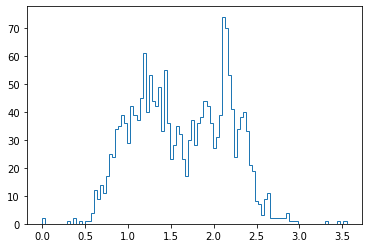

[('6l9m_2', 2.50179875) ('7sg1_0', 2.63744067) ('7sg1_1', 2.94391062)
 ('2xfx_0', 2.78917995) ('4d0c_0', 2.71858066) ('4zus_0', 2.52414441)
 ('5trz_0', 2.82888649) ('5trz_1', 2.67719369) ('2yez_0', 2.55426675)
 ('4g42_0', 2.62906024) ('4g42_1', 2.77004307) ('4zuv_0', 3.47883816)
 ('4zuv_1', 3.54990073) ('3w39_1', 2.64827392) ('4mji_0', 2.54286224)
 ('4mji_1', 2.6011134 ) ('7wt4_0', 2.55121603) ('7wt4_1', 2.62958163)
 ('5ymw_0', 2.65333433) ('5ymw_1', 2.64672463) ('5ymw_2', 2.62956422)
 ('5ymw_3', 2.76707352) ('1zt1_0', 2.63849992) ('5ymv_0', 2.82298866)
 ('5ymv_1', 2.85168691) ('2fo4_0', 2.56071997) ('5ts1_1', 2.56803037)
 ('1jpf_0', 2.86581729) ('7alo_1', 2.52782368) ('2iad_0', 2.63329974)
 ('6wl4_4', 2.6046165 ) ('4e0r_0', 2.74192031) ('4e0r_1', 2.9006964 )
 ('4d0b_0', 2.72559399) ('1ed3_0', 2.60363229) ('4cvz_0', 2.59419357)
 ('4g43_1', 2.86417707) ('1ddh_0', 2.63860655) ('4z78_0', 2.86580115)
 ('4z78_1', 2.96635196) ('6h6h_0', 2.62001864) ('6h6h_1', 2.60655014)
 ('6h6d_0', 2.579885

In [49]:
#plot rmsds
rmsds_array=np.array([(k,v['CA']) for k,v in rmsds.items()],dtype=[('pdb_id','U6'),('rmsd',float)])
plt.figure()
plt.hist(rmsds_array['rmsd'],bins=100,histtype='step')
plt.show()
print(rmsds_array[rmsds_array['rmsd']>2.5])

#4zuv,4zuw: equine
#4e0r: chicken

## save pep geometries

In [50]:
def _get_atom_coords(res,atomname):
    if atomname in res:
        return res[atomname]
    elif 'CA' in res:
        return res['CA']
    else:
        return np.average(list(res.values()),axis=0)  
    
t0=time.time()    
for atomname in ['CA','CB']:    
    pep_coords={}
    for x in os.listdir(pdb_dir+'/pdb_rotated'):
        pdb_id=x.split('.')[0]
        pep_coords[pdb_id]={}
        structure=pdb_tools.parse_pdb(pdb_dir+f'/pdb_rotated/{x}')[0]
        structure_dict=pdb_tools.get_structure_dict(structure,include_coords=True,keep_hetero=True)
        for pdbnum,res in structure_dict['P'].items():
            pep_coords[pdb_id][pdbnum]=_get_atom_coords(res,atomname)
    with open(pdb_dir+f'/peptide_coords_{atomname}.pckl','wb') as f:
        pickle.dump(pep_coords,f)
print('completed in {:5.1f} s'.format(time.time()-t0))

completed in 124.5 s


# assemble records

In [46]:
output_dir=cwd+'/data/experimental_structures/processed_updated'

date_cutoff='2018-04-30' #AlphaFold training set cutoff

## pdbs summary, pmhcs, tcrs, complexes

In [47]:
#assemble records

t0=time.time()
results_all={}
for x in os.listdir(output_dir+f'/proteins'):
    pdb_id_n=x.split('.')[0]
    result={}
    result['pdbid']=pdb_id_n #save pdb_id in result, not only in key
    with open(output_dir+f'/proteins/{x}','rb') as f:
        proteins=pickle.load(f)    
    result.update(proteins)        #add protein objects
    with open(output_dir+f'/pdb_info/{x[:4]+x[-5:]}','rb') as f:
        pdb_info=pickle.load(f)
    #pep hetero and gaps
    if 'P' in proteins:
        if ('X' in proteins['P']['data']['seq']) or ('x' in proteins['P']['data']['seq']):
            result['pep_hetero']=2    #actually includes hetero
        elif proteins['P']['info']['hetero']:
            result['pep_hetero']=1    #hetero atoms in pep chain but not in seq
        else:
            result['pep_hetero']=0
        p=seq_tools.load_NUMSEQ(proteins['P']).ungap_small()
        result['pep_gaps']=len(p.info['gaps'])
    #includes mhc
    if 'M' in result:
        result['includes_mhc']=2   #actually includes
    elif pdb_info['includes_mhc']:
        result['includes_mhc']=1   #blast found MHC-like or B2M, but not included
    else:
        result['includes_mhc']=0
    #includes tcr
    if ('A' in result) or ('B' in result):
        result['includes_tcr']=2   #actually includes
    elif pdb_info['includes_tcr']:
        result['includes_tcr']=1   #blast found TCR-like, but not included
    else:
        result['includes_tcr']=0
    #date and resolution
    result['date']=pdb_info.get('deposition_date') or '1950-01-01'
    result['resolution']=pdb_info.get('resolution') or 10.
    results_all[pdb_id_n]=result
#save
with open(output_dir+'/summary.pckl','wb') as f:
    pickle.dump(results_all,f)
    
print('completed in {:4.1f} s'.format(time.time()-t0))
print('total records:',len(results_all))

#1713 (1697 after cleaning) -> 1963
#pdb search -> 2300 -> 2382

completed in 12.8 s
total records: 2382


In [70]:
#cut linkers in peptides

#for cl 1: cut to the binding core (1-9), since no way to detect proper overhang, and overhang is unlikely;
#for cl 2: cut to 3-residue overhang, i.e., 
#if linker[0] then 0.7,0.8,0.9,...
#if linker[1] then ...,10,11,12
#(then clustering at d=4 should mostly merge irrespectively of linker even for cl 2)

#do cutting in x['P']; keep old seq in x['full_P']

with open(output_dir+'/summary.pckl','rb') as f:
    results_all=pickle.load(f)

l_bdry={'I':'   1 ','II':'   07'}
r_bdry={'I':'   9 ','II':'  12 '}
peps_cut={'I':[],'II':[]}
for k,x in results_all.items():
    if 'P' in x:
        l=x['P']['info']['linker'] #tuple of bool linker flags        
        if np.any(l):            
            x['full_P']={}
            x['full_P']['info']=x['P']['info'].copy()
            x['full_P']['data']=x['P']['data'].copy()            
            cl=x['M']['info']['class']        
            if l[0]:
                pdbnum=x['P']['data']['pdbnum']
                i_l=np.sum(pdbnum<l_bdry[cl])
                x['P']['data']=x['P']['data'][i_l:]
            if l[1]:
                pdbnum=x['P']['data']['pdbnum']
                i_r=np.sum(pdbnum<=r_bdry[cl])            
                x['P']['data']=x['P']['data'][:i_r]
            peps_cut[cl].append([x['P'],x['full_P'],k])
            
with open(output_dir+'/summary.pckl','wb') as f:
    pickle.dump(results_all,f)
            
print('structures w. pep linker, by class:')
for cl,v in peps_cut.items():
    print(cl,len(v))
    for x in v:
        print(''.join(x[0]['data']['seq']),''.join(x[1]['data']['seq']),x[2])

structures w. pep linker, by class:
I 22
ELAGIGILTV ELAGIGILTVggggsggggs 6d7g_0
SIINFEKL SIINFEKLGCGASggggs 5oqf_0
SIINFEKL SIINFEKLGCGASggggs 5oqf_1
YMLDLQPET llwvpgstgYMLDLQPETGGGgsggggs 6e1i_0
SIINFEKL SIINFEKLGCGASggggs 5oqi_0
SIINFEKL SIINFEKLGCGASggggs 5oqi_1
SIINFEKL SIINFEKLGGGASGGGGS 2qrs_0
SIINFEKL SIINFEKLGGGASGGGGS 2qrs_1
AAKKKYCL ararararAAAKKKYCL 6p2c_0
SIINFEKL SIINFEKLGCGASggggs 5oqg_0
SIINFEKL SIINFEKLGCGASggggs 5oqg_1
LLMGTLGIV LLMGTLGIVGGGgsggggs 6apn_0
LLMGTLGIV LLMGTLGIVGgggsggggs 6apn_1
SIINFEKL SIINFEKLGCGASggggs 5oqh_0
SIINFEKL SIINFEKLGCGASggggs 5oqh_1
TAPDNLGKM TAPDNLGKMGgggsggggs 6mp1_0
SIINFEKL SIINFEKLGGGASGGGGS 2qri_0
mVYLKTNVFL mVYLKTNVFLgggasggggs 3nwm_0
TAPDNLGYM TAPDNLGYMGGGgsggggs 6mp0_0
SIINFEKL SIINFEKLGCGASGGGGS 2qrt_0
SIINFEKL SIINFEKLGCGASGGGGS 2qrt_1
SIINFEKL SIINFEKLGGGASGGGGS 2qri_1
II 73
gshsrglKKMREIIGWPGGSG gshsrglKKMREIIGWPGGSGGsgsgsg 3cup_0
VSKMRMATPLLMQAlpmgsgsg pkppkPVSKMRMATPLLMQAlpmgsgsg 1muj_0
FEAQKAKANKAVdg FEAQKAKANKAVdggggslvp 3c6

In [71]:
#assemble pmhcs

with open(output_dir+'/summary.pckl','rb') as f:
    results_all=pickle.load(f)
    
def _sort_pmhc_pdbs(pdbs):
    scores=[(i,x[1]['pep_gaps'],int(x[1]['linker']),x[1]['resolution']) for i,x in enumerate(pdbs)]
    scores=np.array(scores,dtype=[('index',int),('pep_gaps',int),('linker',int),('resolution',float)])
    scores.sort(order=('pep_gaps','linker','resolution'))    
    return [pdbs[s['index']] for s in scores]    

pmhcs={}
pmhcs_pepshift={} #to identify structures with same seq but different pep registers
for pdb_id,r in results_all.items():
    if 'P' in r:
        p=seq_tools.load_NUMSEQ(r['P']).repair_gaps()
        mA=seq_tools.load_NUMSEQ(r['M']).repair_gaps()
        k=p.seq(True)+'|'+mA.seq(True)
        if 'N' in r:            
            mB=seq_tools.load_NUMSEQ(r['N']).repair_gaps()        
            k+='|'+mB.seq(True)                    
        pep_pdbnum=','.join(p.data['pdbnum'])
        pmhcs_pepshift.setdefault(k,{})
        pmhcs_pepshift[k].setdefault(pep_pdbnum,[]).append(pdb_id)
        k+='|'+pep_pdbnum
        pdb_data={'pep_gaps':r['pep_gaps'],'linker':np.any(p.info['linker']),'resolution':r['resolution'],
                 'includes_tcr':r['includes_tcr']}        
        if k in pmhcs:
            pmhcs[k]['pdbs'].append((pdb_id,pdb_data))
            pmhcs[k]['date']=min(pmhcs[k]['date'],r['date'])            
        else:
            pmhcs[k]={'P':p.dump(),'M':mA.dump()}
            if 'N' in r:
                pmhcs[k]['N']=mB.dump()
            pmhcs[k]['class']=mA.info['class']
            pmhcs[k]['pdbs']=[(pdb_id,pdb_data)]
            pmhcs[k]['date']=r['date']
            pmhcs[k]['pep_pdbnum']=pep_pdbnum                     
            
pmhcs1=[]
pdb_to_id={}
for i,v in enumerate(pmhcs.values()):
    v['id']=i
    v['pdbs']=_sort_pmhc_pdbs(v['pdbs'])
    b=False
    u=False
    for x in v['pdbs']:
        pdb_to_id[x[0]]=i
        if x[1]['includes_tcr']:
            b=True
        else:
            u=True
    v['bound']='b'*b+'u'*u
    pmhcs1.append(v)
print('total pmhcs:',len(pmhcs1))
with open(output_dir+'/pmhcs.pckl','wb') as f:
    pickle.dump(pmhcs1,f)      

#add ids to summary
for k,v in results_all.items():
    if 'P' in v:
        v['pmhc_id']=pdb_to_id[k]
with open(output_dir+'/summary.pckl','wb') as f:
    pickle.dump(results_all,f)     
    
#print statistics
n_by_class={}
for x in pmhcs1:
    cl=x['class']
    species=x['M']['info']['species']
    k=cl+'_'+species
    n_by_class.setdefault(k,0)
    n_by_class[k]+=1    
print('pmhc by class and species:',n_by_class)

#total pmhcs: 678 -> 752
#by class:    570, 108 -> 630, 122 -> 703, 127 (human and mouse) or 768, 128 (all)

#after update to 7/2022 seqres:
#total 932
#by class: 731, 131 (human and mouse) or 801, 131 (all)  
#(where did that one non-human/mouse cl II go? probably was primate and became human by g-region reduction)

#after cutting linkers: 928

total pmhcs: 928
pmhc by class and species: {'I_9606': 555, 'I_9823': 18, 'I_10090': 174, 'II_10090': 33, 'II_9606': 96, 'I_9544': 5, 'I_9031': 19, 'I_9913': 4, 'I_9531': 8, 'I_9796': 7, 'I_9545': 1, 'I_8022': 2, 'I_10116': 5, 'I_9541': 1}


In [72]:
#pmhcs after AF cutoff date
n={}
for c in pmhcs1:
    if c['date']>date_cutoff:
        cl=c['class']
        species=c['M']['info']['species']
        k=cl+'_'+species
        n.setdefault(k,0)
        n[k]+=1
print('by class:',n)
#71,9 -> 127, 12 (human and mouse) or 144, 12 (all)
#after update to 7/2022 seqres:
#155, 15 (human and mouse) or 190, 15 (all)

#after cutting linkers: 155, 13

by class: {'I_9606': 136, 'I_9823': 11, 'I_10090': 19, 'I_9544': 3, 'II_9606': 11, 'I_9796': 2, 'I_9031': 3, 'I_9545': 1, 'II_10090': 2, 'I_8022': 1, 'I_10116': 1}


In [73]:
#cl I pmhcs with overhang
with open(output_dir+'/pmhcs.pckl','rb') as f:
    pmhcs1=pickle.load(f)      
for x in pmhcs1:
    if x['class']=='I':
        if (('  10 ' in x['pep_pdbnum']) or ('   09' in x['pep_pdbnum'])) and not np.any(x['P']['info']['linker']):
            print(x['pep_pdbnum'])
            p=seq_tools.load_NUMSEQ(x['P'])
            m=x['M']['info']
            print(p.seq(True),m['locus'],m['allele'])
            print(x['pdbs'])
            print()          

   04,   05,   06,   07,   08,   09,   1 ,   2 ,   3 ,   4 ,   5 ,   7 ,   8 ,   9 
R(MAA)RARAAAKKGYCL B 08:01
[('6p2f_0', {'pep_gaps': 5, 'linker': False, 'resolution': 1.48, 'includes_tcr': 0})]

   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,   8 ,   9 ,  10 
GLKEGIPALD A 02:01
[('5f7d_0', {'pep_gaps': 0, 'linker': False, 'resolution': 2.3, 'includes_tcr': 0})]

   09,   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,   8 ,   9 
TSTTSVASSW B 57:01
[('5t6x_0', {'pep_gaps': 0, 'linker': False, 'resolution': 1.69, 'includes_tcr': 0})]

   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,   8 ,   9 ,  10 ,  11 
GLLPELPAVGG A 02:01
[('5eot_0', {'pep_gaps': 0, 'linker': False, 'resolution': 2.1, 'includes_tcr': 0})]

   09,   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,   8 ,   9 
(ACE)SHVAVENAL B 39:01
[('4o2c_0', {'pep_gaps': 0, 'linker': False, 'resolution': 1.8, 'includes_tcr': 0})]

   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,   8 ,   9 ,  10 ,  11 
LLLPLLPPLSP A 02:01
[('7mj7_0', {'pep_gaps': 0, 'linker': False,

In [74]:
#pmhcs that can adopt multiple binding registers
for k,v in pmhcs_pepshift.items():
    if len(v)>1:
        pdb_id=list(v.values())[0][0]
        mhc_info=results_all[pdb_id]['M']['info']
        print(k.split('|')[0],mhc_info['locus'],mhc_info['allele'],v)
        print()
#2bvq/2bvo, (2guo,3qeq,3qfd,3qdj)/(6eqb,6d78,6eqa), 6amt/6amu, 4z78/4z78

AAGIGILTV A 02:01 {'   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,   8 ,   9 ': ['3qeq_0', '3qdj_0', '2guo_0', '2guo_1', '3qfd_0', '3qfd_1'], '   2 ,   3 ,   4 ,   5 ,   51,   6 ,   7 ,   8 ,   9 ': ['6eqa_0', '6eqb_0', '6d78_0']}

MMWDRGLGMM A 02:01 {'   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,   8 ,   9 ,  10 ': ['6amu_0'], '   1 ,   2 ,   3 ,   4 ,   5 ,   51,   6 ,   7 ,   8 ,   9 ': ['6amt_0', '6amt_1']}

KAFSPEVIPMF B 57:03 {'   1 ,   2 ,   3 ,   4 ,   5 ,   7 ,   8 ,   9 ,  10 ,  11 ,  12 ': ['2bvq_0'], '   1 ,   2 ,   3 ,   4 ,   5 ,   51,   59,   6 ,   7 ,   8 ,   9 ': ['2bvo_0']}

LYLVCGERGF K d {'   1 ,   2 ,   3 ,   4 ,   5 ,   51,   6 ,   7 ,   8 ,   9 ': ['4z78_0'], '   1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,   8 ,   9 ,  10 ': ['4z78_1']}



In [75]:
#assemble tcr chains

with open(output_dir+'/summary.pckl','rb') as f:
    results_all=pickle.load(f)
    
def _sort_tcr_pdbs(pdbs):
    scores=[(i,x[1]['resolution']) for i,x in enumerate(pdbs)]
    scores=np.array(scores,dtype=[('index',int),('resolution',float)])
    scores.sort(order=('resolution'))
    return [pdbs[x['index']] for x in scores]    

tcrs={}
for pdb_id,r in results_all.items():
    for c in ['A','B']:
        if c in r:
            pdb_id1=pdb_id+'_'+c #save chain information in pdb_id
            tcr=seq_tools.load_NUMSEQ(r[c]).repair_gaps()            
            k=tcr.seq(True)           
            pdb_data={'resolution':r['resolution'],'includes_mhc':r['includes_mhc']}
            if k in tcrs:
                tcrs[k]['pdbs'].append((pdb_id1,pdb_data))
                tcrs[k]['date']=min(tcrs[k]['date'],r['date'])            
            else:
                tcrs[k]={}
                tcrs[k]['chain']=tcr.info['chain']
                tcrs[k]['obj']=tcr.dump()           
                tcrs[k]['pdbs']=[(pdb_id1,pdb_data)]
                tcrs[k]['date']=r['date']                

tcrs1=[]
pdb_to_id={}
for i,v in enumerate(tcrs.values()):
    v['id']=i
    v['pdbs']=_sort_tcr_pdbs(v['pdbs'])
    b=False
    u=False
    for x in v['pdbs']:
        pdb_to_id[x[0]]=i
        if x[1]['includes_mhc']:
            b=True
        else:
            u=True
    v['bound']='b'*b+'u'*u
    tcrs1.append(v)
print('total tcr chains:',len(tcrs1))
with open(output_dir+'/tcrs.pckl','wb') as f:
    pickle.dump(tcrs1,f)

#add ids to summary
for k,v in results_all.items():
    for c in ['A','B']:
        if c in v:
            v[f'tcr_{c}_id']=pdb_to_id[k+'_'+c]
with open(output_dir+'/summary.pckl','wb') as f:
    pickle.dump(results_all,f)
    
#print statistics
n_by_chain={}
for x in tcrs1:
    chain=x['chain']
    species=x['obj']['info']['species']
    k=chain+'_'+species
    n_by_chain.setdefault(k,0)
    n_by_chain[k]+=1    
print('tcrs by chain:',n_by_chain)

#total tcrs: was 248 paired (and how many chains?) -> 433 chains (198,215,8,12)
#after pdb search: 455 (207,224,10,14) (all but 2 are human and mouse)
#after seqres upd: 479

total tcr chains: 479
tcrs by chain: {'A_9606': 156, 'B_9606': 172, 'A_10090': 61, 'B_10090': 62, 'D_9606': 14, 'G_9606': 10, 'A_9544': 1, 'B_9541': 1, 'G_10090': 1, 'D_10090': 1}


In [76]:
#assemble complexes

with open(output_dir+'/summary.pckl','rb') as f:
    results_all=pickle.load(f)
    
def _sort_complex_pdbs(pdbs):
    scores=[(i,x[1]['pep_gaps'],int(x[1]['linker']),x[1]['resolution']) for i,x in enumerate(pdbs)]
    scores=np.array(scores,dtype=[('index',int),('pep_gaps',int),('linker',int),('resolution',float)])
    scores.sort(order=('pep_gaps','linker','resolution'))
    return [pdbs[x['index']] for x in scores]      
    
complexes={}    
for pdb_id,r in results_all.items():
    if ('P' in r) and ('A' in r) and ('B' in r):        
        p=seq_tools.load_NUMSEQ(r['P']).repair_gaps()
        mA=seq_tools.load_NUMSEQ(r['M']).repair_gaps()        
        if 'N' in r:            
            mB=seq_tools.load_NUMSEQ(r['N']).repair_gaps()  
        tcr_A=seq_tools.load_NUMSEQ(r['A']).repair_gaps()     
        tcr_B=seq_tools.load_NUMSEQ(r['B']).repair_gaps()     
        pmhc_id=r['pmhc_id']
        tcr_A_id=r['tcr_A_id']
        tcr_B_id=r['tcr_B_id']
        tcr_AB_id=[tcr_A_id,tcr_B_id]
        tcr_AB_id.sort()
        k=(pmhc_id,tuple(tcr_AB_id))
        pdb_data={'pep_gaps':r['pep_gaps'],'linker':np.any(p.info['linker']),'resolution':r['resolution']}
        if k in complexes:
            complexes[k]['pdbs'].append((pdb_id,pdb_data))
            complexes[k]['date']=min(complexes[k]['date'],r['date'])     
        else:
            complexes[k]={'P':p.dump(),'M':mA.dump()}
            if 'N' in r:
                complexes[k]['N']=mB.dump()
            complexes[k].update({'A':tcr_A.dump(),'B':tcr_B.dump()})
            complexes[k].update({'pmhc_id':pmhc_id,'tcr_A_id':tcr_A_id,'tcr_B_id':tcr_B_id})
            complexes[k]['pdbs']=[(pdb_id,pdb_data)]
            complexes[k]['date']=r['date']
            complexes[k]['class']=mA.info['class']

complexes1=[]
pdb_to_id={}
for i,v in enumerate(complexes.values()):
    v['id']=i
    v['pdbs']=_sort_complex_pdbs(v['pdbs'])
    for x in v['pdbs']:
        pdb_to_id[x[0]]=i        
    complexes1.append(v)
print('total complexes:',len(complexes1))
with open(output_dir+'/complexes.pckl','wb') as f:
    pickle.dump(complexes1,f)

#add ids to summary
for k,v in results_all.items():
    if ('P' in v) and ('A' in v) and ('B' in v):
        v['complex_id']=pdb_to_id[k]
with open(output_dir+'/summary.pckl','wb') as f:
    pickle.dump(results_all,f)    
    
#print statistics
n_by_class={}
for x in complexes1:
    cl=x['class']
    species=x['M']['info']['species']
    k=cl+'_'+species
    n_by_class.setdefault(k,0)
    n_by_class[k]+=1    
print('complexes by class:',n_by_class)    

#total complexes: 213 -> 225 (165, 60)
#after pdb search: 234 (172,62), all human and mouse
#after seqres upd: 247 (182,65), all human and mouse

total complexes: 247
complexes by class: {'I_9606': 147, 'II_9606': 40, 'II_10090': 25, 'I_10090': 35}


## cluster pmhcs by seq

In [77]:
with open(output_dir+'/pmhcs.pckl','rb') as f:
    pmhcs=pickle.load(f)
print(len(pmhcs))
print(pmhcs[0].keys())
#752 -> 896 -> 932 -> 928(linkers cut)

928
dict_keys(['P', 'M', 'class', 'pdbs', 'date', 'pep_pdbnum', 'id', 'bound'])


In [79]:
#prepare jobs

output_dir_tmp='/scratch/vmikhayl/tmp_pmhc_seq_distances/distances'   

input_dir='/scratch/vmikhayl/tmp_pmhc_seq_distances'           
input_dir_server=input_dir                                        #helios

cd=cwd

#DELETE OLD OUTPUTS!!! because they are randomly named and are not overwritten
inputs=list(itertools.combinations(np.arange(len(pmhcs)),2))

n_tasks=200 #112#56     #our cluster: 64 nodes * 28 cores
max_run_time=100    #in minutes
qos='short' #medium 
local=False #CHECK!
slow_nodes=[]

sh_path='./scripts/pmhcs_seq_distances.sh'
python_path=cwd+'/tfold/modeling/template_tools.py'
argstring=f'distances_pmhcs {output_dir_tmp} {output_dir}'

n_tasks=utils.make_task(inputs,n_tasks,sh_path,python_path,input_dir,input_dir_server=input_dir_server,
                        qos=qos,max_run_time=max_run_time,slow_nodes=slow_nodes,local=local,argstring=argstring,cd=cd)
print('n tasks:',n_tasks)

n tasks: 200


In [80]:
#assemble results
distances={}
for x in os.listdir(output_dir_tmp):
    with open(output_dir_tmp+f'/{x}','rb') as f:        
        d=pickle.load(f)        
        distances.update(d)
print(len(distances))   
l=len(pmhcs)
print(l*(l-1)/2)

dist_matrix=np.zeros((len(pmhcs),len(pmhcs))) #symmetric distance matrix
for i in range(len(pmhcs)):
    for j in range(len(pmhcs)):
        dist_matrix[i,j]=distances.get((i,j)) or distances.get((j,i)) or 0    
print(dist_matrix.shape,len(pmhcs))        

#400960 -> 433846

430128
430128.0
(928, 928) 928


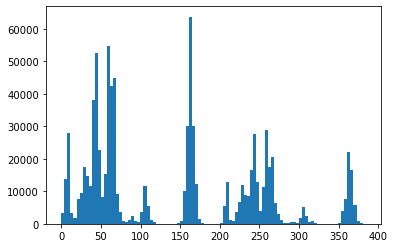

In [81]:
#shift distances between discovery and test sets to put them in separate clusters
i_before=[i for i,x in enumerate(pmhcs) if x['date']<date_cutoff]
i_after =[i for i,x in enumerate(pmhcs) if x['date']>=date_cutoff]
for i in i_before:
    for j in i_after:
        dist_matrix[i,j]+=200
        dist_matrix[j,i]+=200
plt.figure()
plt.hist(dist_matrix.reshape((len(pmhcs)**2)),bins=100)
plt.show()

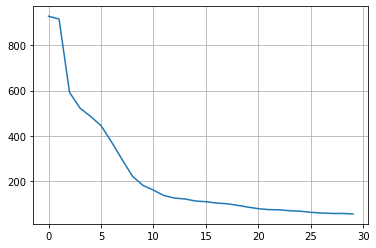

total clusters: 486
by class: {'I': 398, 'II': 88}
cluster sizes:
1  312
2   87
3   33
4   23
6    9
5    7
8    6
15   3
7    1
9    1
11   1
12   1
13   1
17   1
examples:
 93 AAVYNFATM            D*b                 
136 KGPSNFATM            D*b                 
215 KAPYDYAPI            D*b                 
241 KAPANFATM            D*b                 
253 KAVANFATM            D*b                 
323 KAVYNFATM            D*b                 
417 KAPFNFATM            D*b                 
434 KAPYNFATM            D*b                 
504 KALYNYAPI            D*b                 
563 KAVFNFATM            D*b                 
567 KAVYNLATM            D*b                 
694 KGPANFATM            D*b                 
709 KAVSNFATM            D*b                 
771 SAVYNFATM            D*b                 
790 KALYNFATM            D*b                 
802 KAVYNFATC            D*b                 
919 KAPSNFATM            D*b                 

 61 LLYGFVNYI            A*02:01           

In [82]:
#cluster
     
dist_matrix=squareform(dist_matrix)           #condensed distance matrix  
Z=cluster.hierarchy.linkage(dist_matrix,method='single')
#plot cluster number vs cutoff
sizes=[len(np.unique(cluster.hierarchy.cut_tree(Z,height=d))) for d in range(30)]
plt.figure()
plt.plot(sizes)
plt.grid()
plt.show()

#set threshold
d=4
ZZ=cluster.hierarchy.cut_tree(Z,height=d)
cluster_list=[np.nonzero(ZZ==x)[0] for x in range(len(np.unique(ZZ)))] #clusters in order id=0, id=1, ...
print('total clusters:',len(cluster_list))
n_cl={'I':0,'II':0}
for c in cluster_list:
    n_cl[pmhcs[c[0]]['class']]+=1    
print('by class:',n_cl)
print('cluster sizes:')
cl_len=np.array([len(c) for c in cluster_list])
ind=np.argsort(-cl_len)
utils.print_hist(cl_len,order=-1)
print('examples:')
for c in ind[:5]:
    for i in cluster_list[c]:
        pepseq=''.join(pmhcs[i]['P']['data']['seq'])
        mhcallele='*'.join((pmhcs[i]['M']['info']['locus'],pmhcs[i]['M']['info']['allele']))
        if 'N' in pmhcs[i]:
            mhcallele+='|'+'*'.join((pmhcs[i]['N']['info']['locus'],pmhcs[i]['N']['info']['allele']))
        print('{:3d} {:20s} {:20s}'.format(i,pepseq,mhcallele))
    print()
    
#359 (278, 81) 

#after pdb search 
#453 (366,87)

#after 7/2022 seqres and splitting discovery/test sets by distance shift
#491 (400,91)
#linkers removed
#486 (398,88)

In [83]:
#save clusters
for i in range(len(pmhcs)):
    pmhcs[i]['cluster_seq']=ZZ[i][0]
with open(output_dir+'/pmhcs.pckl','wb') as f:
    pickle.dump(pmhcs,f)    

def _sort_pmhc_pdbs(pdbs):
    scores=[(i,x[1]['pep_gaps'],int(x[1]['linker']),x[1]['resolution']) for i,x in enumerate(pdbs)]
    scores=np.array(scores,dtype=[('index',int),('pep_gaps',int),('linker',int),('resolution',float)])
    scores.sort(order=('pep_gaps','linker','resolution'))    
    return [pdbs[s['index']] for s in scores]    

pmhcs_clusters=[]
for i,c in enumerate(cluster_list):
    d={}
    d['id']=i
    d['pmhc_ids']=c
    d['pdbs']=_sort_pmhc_pdbs([x for j in c for x in pmhcs[j]['pdbs']])
    d['date']=min([pmhcs[j]['date'] for j in c])
    pmhcs_clusters.append(d)
with open(output_dir+'/pmhcs_seq_clusters.pckl','wb') as f:
    pickle.dump(pmhcs_clusters,f)            

In [84]:
#clusters after AF cutoff date
n={}
for c in pmhcs_clusters:
    if c['date']>date_cutoff:
        cl=pmhcs[c['pmhc_ids'][0]]['class']
        n.setdefault(cl,0)
        n[cl]+=1
print('by class:',n)
# 30,6 -> 73,9 -> 107,13->107,12

by class: {'I': 107, 'II': 12}


In [85]:
#species stats
ks=[]
for x in pmhcs_clusters:
    y=pmhcs[x['pmhc_ids'][0]]
    cl=y['class']
    sp=seq_tools.species[y['M']['info']['species']][2]
    ks.append(cl+'_'+sp)
    if sp=='Rainbow Trout':
        print(x)
utils.print_hist(ks,order=-1)
#I 316, II 86 human and mouse
#I 50, II 1 others

#after seqres update:
#I 341, II 91 human and mouse
#I 59, II 0 others (missing cl II probably migrated from monkey to human because of g-region reduction)
#linkers removed:...

{'id': 257, 'pmhc_ids': array([381]), 'pdbs': [('6lup_0', {'pep_gaps': 0, 'linker': False, 'resolution': 2.3, 'includes_tcr': 0}), ('6lup_1', {'pep_gaps': 0, 'linker': False, 'resolution': 2.3, 'includes_tcr': 0})], 'date': '2020-01-30'}
{'id': 322, 'pmhc_ids': array([514]), 'pdbs': [('5h5z_0', {'pep_gaps': 0, 'linker': False, 'resolution': 1.74, 'includes_tcr': 0}), ('5y91_0', {'pep_gaps': 0, 'linker': False, 'resolution': 1.9, 'includes_tcr': 0}), ('6lbe_0', {'pep_gaps': 0, 'linker': False, 'resolution': 2.6, 'includes_tcr': 0}), ('6lbe_1', {'pep_gaps': 0, 'linker': False, 'resolution': 2.6, 'includes_tcr': 0})], 'date': '2016-11-10'}
I_human                       264
I_mouse                        75
II_human                       65
II_mouse                       23
I_Feral Pig                    16
I_Chicken                      14
I_Horse                         6
I_Sooty Mangabey                6
I_Norway Rat                    5
I_rhesus monkey                 5
I_Cattle       

## cluster tcrs by seq

In [86]:
with open(output_dir+'/tcrs.pckl','rb') as f:
    tcrs=pickle.load(f)
print(len(tcrs))
print(tcrs[0].keys())
#433->455->479

479
dict_keys(['chain', 'obj', 'pdbs', 'date', 'id', 'bound'])


In [87]:
#prepare jobs #REMOVE OLD DISTANCE FILES!!

output_dir_tmp='/scratch/vmikhayl/tmp_tcr_seq_distances/distances'   

input_dir='/scratch/vmikhayl/tmp_tcr_seq_distances'           
#input_dir_server='/scratch/lustre/vmikhayl/tmp_pdb_processing'   #typhon
input_dir_server=input_dir                                        #helios

cd=cwd

inputs=list(itertools.combinations(range(len(tcrs)),2))

n_tasks=200 #112#56     #our cluster: 64 nodes * 28 cores
max_run_time=100    #in minutes
qos='short' #medium 
local=False #CHECK!
slow_nodes=[]

sh_path='./scripts/tcrs_seq_distances.sh'
python_path=cwd+'/tfold/modeling/template_tools.py'
argstring=f'distances_tcrs {output_dir_tmp} {output_dir}'

n_tasks=utils.make_task(inputs,n_tasks,sh_path,python_path,input_dir,input_dir_server=input_dir_server,
                        qos=qos,max_run_time=max_run_time,slow_nodes=slow_nodes,local=local,argstring=argstring,cd=cd)
print('n tasks:',n_tasks)

n tasks: 200


In [88]:
#assemble results
distances={}
for x in os.listdir(output_dir_tmp):
    with open(output_dir_tmp+f'/{x}','rb') as f:
        distances.update(pickle.load(f))
print(len(distances))   
l=len(tcrs)
print(l*(l-1)/2)

dist_matrix=np.zeros((len(tcrs),len(tcrs))) #symmetric distance matrix
for i in range(len(tcrs)):
    for j in range(len(tcrs)):
        dist_matrix[i,j]=distances.get((i,j)) or distances.get((j,i)) or 0 #indexed by indices of list pmhcs_ind
print(dist_matrix.shape,len(tcrs))

114481
114481.0
(479, 479) 479


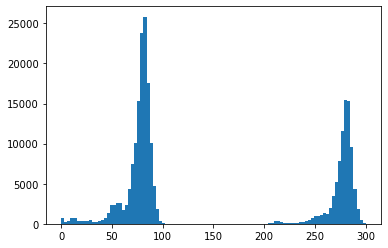

In [89]:
#shift distances between discovery and test sets to put them in separate clusters
i_before=[i for i,x in enumerate(tcrs) if x['date']<date_cutoff]
i_after =[i for i,x in enumerate(tcrs) if x['date']>=date_cutoff]
for i in i_before:
    for j in i_after:
        dist_matrix[i,j]+=200
        dist_matrix[j,i]+=200
plt.figure()
plt.hist(dist_matrix.reshape((len(tcrs)**2)),bins=100)
plt.show()

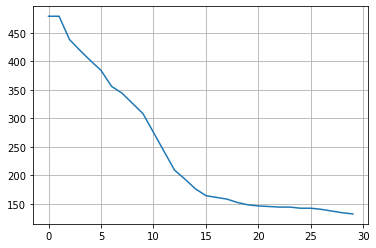

total clusters: 401
by chain: {'A': 177, 'B': 200, 'D': 15, 'G': 9}
cluster sizes:
1  358
2   31
3    7
4    1
5    1
6    1
11   1
12   1
examples:
TRAV1-2*01 TRAJ33*01 9606 CAVKDSNYQLIW
TRAV1-2*01 TRAJ33*01 9606 CAAEDSNYQLIW
TRAV1-2*01 TRAJ33*01 9606 CAVVDSNYQLIW
TRAV1-2*01 TRAJ33*01 9606 CAVRDSNYQLIW
TRAV1-2*01 TRAJ33*01 9606 CAFMDSNYQLIW
TRAV1-2*01 TRAJ33*01 9606 CAGMDSNYQLIW
TRAV1-2*01 TRAJ33*01 9606 CAPLDSNYQLIW
TRAV1-2*01 TRAJ33*01 9606 CASIDSNYQLIW
TRAV1-2*01 TRAJ33*01 9606 CAVMDSNYQLIW
TRAV1-2*01 TRAJ33*01 9606 CASMDSNYQLIW
TRAV1-2*01 TRAJ33*01 9606 CAAMDSNYQLIW
TRAV1-2*01 TRAJ33*01 9606 CAVMDSNFQLIW

TRBV13-2*01 TRBJ2-4*01 10090 CASGVGGTLYF
TRBV13-2*01 TRBJ2-4*01 10090 CASGVGGTLYF
TRBV13-2*01 TRBJ2-4*01 10090 CASGGGGTLYF
TRBV13-2*01 TRBJ2-4*01 10090 CASGGGGTLYF
TRBV13-2*01 TRBJ2-4*01 10090 CASGGGGTLYF
TRBV13-2*01 TRBJ2-4*01 10090 CASGGGGTLYF
TRBV13-2*01 TRBJ2-4*01 10090 CASGGGGTLYF
TRBV13-2*01 TRBJ2-4*01 10090 CASGVGGTLYF
TRBV13-2*01 TRBJ2-4*01 10090 CASGGGGTLYF
TRBV13-2*01 T

In [90]:
#cluster

dist_matrix=squareform(dist_matrix)           #condensed distance matrix  
Z=cluster.hierarchy.linkage(dist_matrix,method='single')
#plot cluster number vs cutoff
sizes=[len(np.unique(cluster.hierarchy.cut_tree(Z,height=d))) for d in range(30)]
plt.figure()
plt.plot(sizes)
plt.grid()
plt.show()

#set threshold
d=4
ZZ=cluster.hierarchy.cut_tree(Z,height=d)
cluster_list=[np.nonzero(ZZ==x)[0] for x in range(len(np.unique(ZZ)))]
print('total clusters:',len(cluster_list))
n_chain={}
for c in cluster_list:
    chain=tcrs[c[0]]['chain']
    n_chain.setdefault(chain,0)
    n_chain[chain]+=1
print('by chain:',n_chain)
print('cluster sizes:')
cl_len=np.array([len(c) for c in cluster_list])
ind=np.argsort(-cl_len)
utils.print_hist(cl_len,order=-1)
print('examples:')
for c in ind[:5]:
    for i in cluster_list[c]:
        x=seq_tools.load_NUMSEQ(tcrs[i]['obj'])
        cdr3=x.get_fragment_by_pdbnum(' 104 ',' 118 ').seq()
        print(x.info['V'],x.info['J'],x.info['species'],cdr3)        
    print()
    
#   354 (156,179,7,12)
#-> 375 (165,188,8,14)
#-> 401 (177,200,9,15)

In [91]:
#save clusters
for i in range(len(tcrs)):
    tcrs[i]['cluster_seq']=ZZ[i][0]
with open(output_dir+'/tcrs.pckl','wb') as f:
    pickle.dump(tcrs,f)    

def _sort_tcr_pdbs(pdbs):
    scores=[(i,x[1]['resolution']) for i,x in enumerate(pdbs)]
    scores=np.array(scores,dtype=[('index',int),('resolution',float)])
    scores.sort(order=('resolution'))
    return [pdbs[x['index']] for x in scores]   

tcrs_clusters=[]
for i,c in enumerate(cluster_list):
    d={}
    d['id']=i
    d['tcr_ids']=c
    d['pdbs']=_sort_tcr_pdbs([x for j in c for x in tcrs[j]['pdbs']])
    d['date']=min([tcrs[j]['date'] for j in c])
    tcrs_clusters.append(d)
with open(output_dir+'/tcrs_seq_clusters.pckl','wb') as f:
    pickle.dump(tcrs_clusters,f)            

In [92]:
#clusters after AF cutoff date
n={}
for c in tcrs_clusters:
    if c['date']>date_cutoff:
        chain=tcrs[c['tcr_ids'][0]]['chain']
        n.setdefault(chain,0)
        n[chain]+=1
print('by chain:',n)
#   33,32,1,1
#-> 41,40,2,2
#-> 53,52,3,3

by chain: {'A': 53, 'B': 52, 'G': 3, 'D': 3}


## cluster complexes by seq

In [93]:
with open(output_dir+'/pmhcs.pckl','rb') as f:
    pmhcs=pickle.load(f)
print(len(pmhcs))
print(pmhcs[0].keys())

with open(output_dir+'/tcrs.pckl','rb') as f:
    tcrs=pickle.load(f)
print(len(tcrs))
print(tcrs[0].keys())

with open(output_dir+'/complexes.pckl','rb') as f:
    complexes=pickle.load(f)
print(len(complexes))
print(complexes[0].keys())

928
dict_keys(['P', 'M', 'class', 'pdbs', 'date', 'pep_pdbnum', 'id', 'bound', 'cluster_seq'])
479
dict_keys(['chain', 'obj', 'pdbs', 'date', 'id', 'bound', 'cluster_seq'])
247
dict_keys(['P', 'M', 'A', 'B', 'pmhc_id', 'tcr_A_id', 'tcr_B_id', 'pdbs', 'date', 'class', 'id'])


In [95]:
for x in complexes:
    x['pmhc_cluster_seq']=pmhcs[x['pmhc_id']]['cluster_seq']
    x['tcr_A_cluster_seq']=tcrs[x['tcr_A_id']]['cluster_seq']
    x['tcr_B_cluster_seq']=tcrs[x['tcr_B_id']]['cluster_seq']
complexes_clusters={}
for i,c in enumerate(complexes):
    k_tcr=[c['tcr_A_cluster_seq'],c['tcr_B_cluster_seq']]
    k_tcr.sort()
    k=(c['pmhc_cluster_seq'],tuple(k_tcr))
    complexes_clusters.setdefault(k,[]).append(i)
complexes_clusters=list(complexes_clusters.values())
print('total clusters:',len(complexes_clusters))
n_cl={'I':0,'II':0}
for c in complexes_clusters:
    n_cl[complexes[c[0]]['class']]+=1    
print('by class:',n_cl)
print('cluster sizes:')
ls=np.array([len(c) for c in complexes_clusters])
ind=np.argsort(-ls)
utils.print_hist(ls)
print('examples:')
for i in ind[:5]:
    for c in complexes_clusters[i]:
        cc=complexes[c]
        print(''.join(cc['P']['data']['seq']))
        print(cc['M']['info']['locus'],cc['M']['info']['allele'])
        if 'N' in cc:
            print(cc['N']['info']['locus'],cc['N']['info']['allele'])
        x=seq_tools.load_NUMSEQ(cc['A'])
        cdr3=x.get_fragment_by_pdbnum(' 104 ',' 118 ').seq()
        print(x.info['V'],x.info['J'],x.info['species'],cdr3) 
        x=seq_tools.load_NUMSEQ(cc['B'])
        cdr3=x.get_fragment_by_pdbnum(' 104 ',' 118 ').seq()
        print(x.info['V'],x.info['J'],x.info['species'],cdr3) 
    print()
        
id_to_cluster={}
for i,c in enumerate(complexes_clusters):
    for x in c:
        id_to_cluster[x]=i
        
#   153 (105,48)        
#-> 159 (109,50)
#-> 178 (122,56) (seqres 7/2022, no change after cutting linkers)

total clusters: 178
by class: {'I': 122, 'II': 56}
cluster sizes:
1 144
2  19
3   7
4   3
5   1
6   3
9   1
examples:
LLFGXPVYV
A 02:01
TRAV12-2*02 TRAJ24*02 9606 CAVTTDSWGKLQF
TRBV6-5*01 TRBJ2-7*01 9606 CASRPGLAGGRPEQYF
LLFGYPVAV
A 02:01
TRAV12-2*02 TRAJ24*02 9606 CAVTTDSWGKLQF
TRBV6-5*01 TRBJ2-7*01 9606 CASRPGLAGGRPEQYF
LLFGFPVYV
A 02:01
TRAV12-2*02 TRAJ24*02 9606 CAVTTDSWGKLQF
TRBV6-5*01 TRBJ2-7*01 9606 CASRPGLAGGRPEQYF
LLFGYPVYV
A 02:01
TRAV12-2*02 TRAJ24*02 9606 CAVTTDSWGKLQF
TRBV6-5*01 TRBJ2-7*01 9606 CASRPGLAGGRPEQYF
LLFGYPRYV
A 02:01
TRAV12-2*02 TRAJ24*02 9606 CAVTTDSWGKLQF
TRBV6-5*01 TRBJ2-7*01 9606 CASRPGLAGGRPEQYF
LGYGFVNYI
A 02:01
TRAV12-2*02 TRAJ24*02 9606 CAVTTDSWGKLQF
TRBV6-5*01 TRBJ2-7*01 9606 CASRPGLAGGRPEQYF
LLFGXPVYV
A 02:01
TRAV12-2*02 TRAJ24*02 9606 CAVTTDSWGKLQF
TRBV6-5*01 TRBJ2-7*01 9606 CASRPGLAGGRPEQYF
LLFGYAVYV
A 02:01
TRAV12-2*02 TRAJ24*02 9606 CAVTTDSWGKLQF
TRBV6-5*01 TRBJ2-7*01 9606 CASRPGLAGGRPEQYF
LLFGKPVYV
A 02:01
TRAV12-2*02 TRAJ24*02 9606 CAVTTDSWGKLQF

In [96]:
#save

for i,c in enumerate(complexes):
    c['complex_cluster_seq']=id_to_cluster[i]    
with open(output_dir+'/complexes.pckl','wb') as f:
    pickle.dump(complexes,f) 

def _sort_complex_pdbs(pdbs):
    scores=[(i,x[1]['pep_gaps'],int(x[1]['linker']),x[1]['resolution']) for i,x in enumerate(pdbs)]
    scores=np.array(scores,dtype=[('index',int),('pep_gaps',int),('linker',int),('resolution',float)])
    scores.sort(order=('pep_gaps','linker','resolution'))
    return [pdbs[x['index']] for x in scores]  

c_clusters=[]
for i,c in enumerate(complexes_clusters):
    d={}
    d['id']=i
    d['complex_ids']=c
    d['pdbs']=_sort_complex_pdbs([x for j in c for x in complexes[j]['pdbs']])
    d['date']=min([complexes[j]['date'] for j in c])
    c_clusters.append(d)
with open(output_dir+'/complex_seq_clusters.pckl','wb') as f:
    pickle.dump(c_clusters,f)            

In [97]:
#clusters after AF cutoff date
n={}
for c in c_clusters:
    if c['date']>date_cutoff:
        cl=complexes[c['complex_ids'][0]]['class']
        n.setdefault(cl,0)
        n[cl]+=1
print('by class:',n)
#   18, 9
#-> 22,11
#-> 36,17 (seqres 7/2022)

by class: {'I': 35, 'II': 17}


## cluster pmhcs by CA/CB

In [98]:
atom='CA' #which distances to cluster by

#load
with open(output_dir+'/pmhcs.pckl','rb') as f:
    pmhcs=pickle.load(f)
print('pmhcs:')
print(len(pmhcs))
print(pmhcs[0].keys())
with open(output_dir+f'/peptide_coords_{atom}.pckl','rb') as f:
    pep_coords=pickle.load(f)
pep_coords_reduced=[pep_coords[x['pdbs'][0][0]] for x in pmhcs] #one per pmhc id

#shift coords after date cutoff, to enforce cluster separation
shift=10.
for x,y in zip(pep_coords_reduced,pmhcs):
    if y['date']>=date_cutoff:
        for k in x:
            x[k]+=shift

#split by class
pep_coords_split={'I':[],'II':[]}
ind_split={}
ind_split_reverse={'I':{},'II':{}}
for i,x in enumerate(pmhcs):
    cl=x['class']
    ind_split[i]=len(pep_coords_split[cl])
    ind_split_reverse[cl][len(pep_coords_split[cl])]=i
    pep_coords_split[cl].append(pep_coords_reduced[i])      
#transform pep_coords into fixed size arrays
reskeep=['{:4d} '.format(i) for i in range(1,10)]
reskeep={'I':reskeep,'II':['   09']+reskeep+['  10 ']} #keep 1-9 for cl I, 09-10 for cl II
pep_coords_window={'I':[],'II':[]}
for cl,peps in pep_coords_split.items():
    for x in peps:
        resnames=np.sort(list(x.keys()))
        c_coords=[]
        for r in reskeep[cl]:
            if r in x:
                c_coords.append(x[r])
            else: #impute from neighbors
                r_mp=[]
                r_m=resnames[resnames<r]
                if len(r_m)>0:
                    r_mp.append(r_m[-1])
                r_p=resnames[resnames>r]
                if len(r_p)>0:
                    r_mp.append(r_p[0])
                c_coords.append(np.average([x[a] for a in r_mp],axis=0))
        pep_coords_window[cl].append(c_coords)
    pep_coords_window[cl]=np.array(pep_coords_window[cl]).reshape(-1,len(reskeep[cl])*3)
    
#define centroids from seq clusters
clusters_seq_used=set()
centroids={'I':[],'II':[]}
for cl in centroids:
    for i,xyz in enumerate(pep_coords_window[cl]):
        x=pmhcs[ind_split_reverse[cl][i]]
        if x['cluster_seq'] not in clusters_seq_used:
                centroids[cl].append(pep_coords_window[cl][i])
                clusters_seq_used.add(x['cluster_seq'])    
    centroids[cl]=np.array(centroids[cl])
    print(f'centroids for cl {cl}: {centroids[cl].shape}')    

#explore cluster numbers
if False:
    ranges={'CA':{'I':(150,250,10),'II':(40,70,5)},
            'CB':{'I':(270,330,10),'II':(20,80,10)}}
    for cl in ['I','II']:
        print(cl)
        for k in np.arange(*ranges[atom][cl]):        
            X=cluster.vq.kmeans(pep_coords_window[cl],k)
            print(k,X[1])            
    #choice:
    k_chosen={'CA':{'I':200,'II':50},
              'CB':{'I':300,'II':70}}    
#assign clusters
X={}
Y={}
for cl in ['I','II']:        
    #X=cluster.vq.kmeans(pep_coords_window[cl],k_chosen[atom][cl])    
    X[cl]=cluster.vq.kmeans(pep_coords_window[cl],centroids[cl])
    print(f'k-means dispersion for cl {cl}:',X[cl][1])
    print('output X shape:',X[cl][0].shape)
    Y[cl]=cluster.vq.vq(pep_coords_window[cl],X[cl][0])[0]+X['I'][0].shape[0]*(cl=='II') #shift cluster indices for cl II    
Y=np.array([Y[x['class']][ind_split[i]] for i,x in enumerate(pmhcs)]) #array of len(pmhcs) cluster indices 
clusters=[np.nonzero(Y==x)[0] for x in range(len(np.unique(Y)))] #list of len(clusters) lists of pmhcs indices
    
print('total clusters:',len(clusters))
n_cl={'I':0,'II':0}
for c in clusters:
    n_cl[pmhcs[c[0]]['class']]+=1    
print('by class:',n_cl)
print('cluster sizes:')
cl_len=np.array([len(c) for c in clusters])
ind=np.argsort(-cl_len)
utils.print_hist(cl_len,order=-1)
print('examples:')
for c in ind[:5]:
    print('distance cluster id:',c)
    print('pmhc_id, cluster_seq, pepseq, mhc')
    for i in clusters[c]:
        pepseq=''.join(pmhcs[i]['P']['data']['seq'])
        mhcallele='*'.join((pmhcs[i]['M']['info']['locus'],pmhcs[i]['M']['info']['allele']))
        if 'N' in pmhcs[i]:
            mhcallele+='*'.join((pmhcs[i]['N']['info']['locus'],pmhcs[i]['N']['info']['allele']))
        print('{:3d} {:3d} {:15s} {:20s}'.format(i,pmhcs[i]['cluster_seq'],pepseq,mhcallele))
    print()
    
#dispersions 0.668,0.458 -> 0.600, 0.422 -> 0.609,0.284

pmhcs:
928
dict_keys(['P', 'M', 'class', 'pdbs', 'date', 'pep_pdbnum', 'id', 'bound', 'cluster_seq'])
centroids for cl I: (398, 27)
centroids for cl II: (88, 33)
k-means dispersion for cl I: 0.61089784
output X shape: (398, 27)
k-means dispersion for cl II: 0.40342826
output X shape: (88, 33)
total clusters: 486
by class: {'I': 398, 'II': 88}
cluster sizes:
1  286
2   97
3   51
4   19
5   17
7    5
6    4
9    4
8    1
15   1
16   1
examples:
distance cluster id: 74
pmhc_id, cluster_seq, pepseq, mhc
 93  86 AAVYNFATM       D*b                 
136  86 KGPSNFATM       D*b                 
215  86 KAPYDYAPI       D*b                 
241  86 KAPANFATM       D*b                 
253  86 KAVANFATM       D*b                 
300 214 KVPRNQDWL       D*b                 
323  86 KAVYNFATM       D*b                 
376 214 EGPRNQDWL       D*b                 
408 214 EGPRNQDWL       D*b                 
417  86 KAPFNFATM       D*b                 
563  86 KAVFNFATM       D*b                 


In [99]:
#save clusters
for i in range(len(pmhcs)):
    pmhcs[i][f'cluster_{atom}']=Y[i]
with open(output_dir+'/pmhcs.pckl','wb') as f:
    pickle.dump(pmhcs,f)    

def _sort_pmhc_pdbs(pdbs):
    scores=[(i,x[1]['pep_gaps'],int(x[1]['linker']),x[1]['resolution']) for i,x in enumerate(pdbs)]
    scores=np.array(scores,dtype=[('index',int),('pep_gaps',int),('linker',int),('resolution',float)])
    scores.sort(order=('pep_gaps','linker','resolution'))    
    return [pdbs[s['index']] for s in scores]    

pmhcs_clusters=[]
for i,c in enumerate(clusters):
    d={}
    d['id']=i
    d['pmhc_ids']=c
    d['pdbs']=_sort_pmhc_pdbs([x for j in c for x in pmhcs[j]['pdbs']])
    d['date']=min([pmhcs[j]['date'] for j in c])
    pmhcs_clusters.append(d)
with open(output_dir+f'/pmhcs_{atom}_clusters.pckl','wb') as f:
    pickle.dump(pmhcs_clusters,f)            

In [100]:
#check if before and after cutoff are mixed in same cluster
mixed_clusters=[]
for x in pmhcs_clusters:
    dates=np.array([pmhcs[i]['date'] for i in x['pmhc_ids']])
    if np.any(dates<date_cutoff)&np.any(dates>=date_cutoff):
        mixed_clusters.append(x)
print(len(mixed_clusters))

0


In [101]:
#check how distance clusters and seq clusters interact
def _atom_distance(i,j):
    ca,cb=pep_coords_reduced[i],pep_coords_reduced[j]
    d=0
    intersect=set(ca.keys())&set(cb.keys())
    intersect=[x for x in intersect if x>='   09' and x<='  10 '] #restrict    
    for k in intersect:
        v=ca[k]-cb[k]
        d+=np.dot(v,v)
    return (d/len(intersect))**0.5
id_summary=[]
for x in pmhcs:
    id_summary.append([x['id'],x['cluster_seq'],x[f'cluster_{atom}']])
id_summary=np.array(id_summary)

#C-clusters with many different seq-clusters
print('same distance cluster, multiple seq clusters')
lens=np.array([[x,len(np.unique(id_summary[id_summary[:,2]==x,1]))] for x in np.unique(id_summary[:,2])])
lens=lens[np.argsort(-lens[:,1])]
for c in lens[:5][:,0]:
    subset=id_summary[id_summary[:,2]==c]
    for i in subset[:,0]:
        x=pmhcs[i]
        pepseq=''.join(x['P']['data']['seq'])
        mhcallele='*'.join((x['M']['info']['locus'],x['M']['info']['allele']))
        if 'N' in x:
            mhcallele+=' '+'*'.join((x['N']['info']['locus'],x['N']['info']['allele']))
        print('{:3d} {:3d} {:3d} {:15s} {:20s}'.format(i,x['cluster_seq'],x[f'cluster_{atom}'],pepseq,mhcallele))
    print('pairwise distances:')
    for a,b in itertools.combinations(np.unique(subset[:,1]),2):
        j1,j2=subset[subset[:,1]==a][0,0],subset[subset[:,1]==b][0,0]
        print('{:3d} {:3d} {:4.2f} {:6s} {:6s}'.format(j1,j2,_atom_distance(j1,j2),pmhcs[j1]['pdbs'][0][0],pmhcs[j2]['pdbs'][0][0]))
    print()
    
#C-clusters with many different seq-clusters
print('same seq cluster, multiple distance clusters')
lens=np.array([[x,len(np.unique(id_summary[id_summary[:,1]==x,2]))] for x in np.unique(id_summary[:,1])])
lens=lens[np.argsort(-lens[:,1])]
for c in lens[:5][:,0]:
    subset=id_summary[id_summary[:,1]==c]
    for i in subset[:,0]:
        x=pmhcs[i]
        pepseq=''.join(x['P']['data']['seq'])
        mhcallele='*'.join((x['M']['info']['locus'],x['M']['info']['allele']))
        if 'N' in x:
            mhcallele+=' '+'*'.join((x['N']['info']['locus'],x['N']['info']['allele']))
        print('{:3d} {:3d} {:3d} {:15s} {:20s}'.format(i,x['cluster_seq'],x[f'cluster_{atom}'],pepseq,mhcallele))
    print('pairwise distances:')
    for a,b in itertools.combinations(np.unique(subset[:,2]),2):
        j1,j2=subset[subset[:,2]==a][0,0],subset[subset[:,2]==b][0,0]
        print('{:3d} {:3d} {:4.2f} {:6s} {:6s}'.format(j1,j2,_atom_distance(j1,j2),pmhcs[j1]['pdbs'][0][0],pmhcs[j2]['pdbs'][0][0]))
    print()    

same distance cluster, multiple seq clusters
179 149 127 AIVNYANL        K*b                 
352 101 127 AVYNFATM        K*b                 
360  94 127 EIINFEKL        K*b                 
392  94 127 SIINFEKL        K*b                 
554 342 127 SQYYYNSL        K*b                 
823 206 127 SSIEFARL        K*b                 
834 101 127 AVYNFATM        K*b                 
887  94 127 SIIGFEKL        K*b                 
pairwise distances:
360 352 0.35 3pab_0 4hs3_0
360 179 0.34 3pab_0 3tie_0
360 823 0.30 3pab_0 1t0m_0
360 554 0.54 3pab_0 2clv_0
352 179 0.34 4hs3_0 3tie_0
352 823 0.36 4hs3_0 1t0m_0
352 554 0.36 4hs3_0 2clv_0
179 823 0.25 3tie_0 1t0m_0
179 554 0.40 3tie_0 2clv_0
823 554 0.42 1t0m_0 2clv_0

213 170 204 ILKEPVHGV       A*02:01             
231  32 204 SLYLTVATL       A*02:01             
344 239 204 GLMWLSYFV       A*02:01             
374  32 204 SLANTVATL       A*02:01             
391 124 204 ILSALVGIV       A*02:01             
671   4 204 NLVXMVATV      

775
878


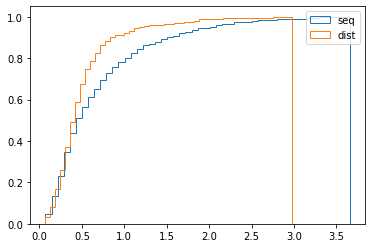

In [102]:
#compare distribution of distances within seq clusters and within distance clusters

select=1
pairs=[]
for N in range(10):
    for i in np.unique(id_summary[:,select]):
        ind=np.nonzero(id_summary[:,select]==i)[0]
        ind=np.random.permutation(ind)
        if len(ind)>1:
            pairs.append((id_summary[ind[0],0],id_summary[ind[1],0]))    
pairs=list(set(pairs))
print(len(pairs))
ds1=[]
for p in pairs:    
    ds1.append(_atom_distance(*p))

select=2
pairs=[]
for N in range(10):
    for i in np.unique(id_summary[:,select]):
        ind=np.nonzero(id_summary[:,select]==i)[0]
        ind=np.random.permutation(ind)
        if len(ind)>1:
            pairs.append((id_summary[ind[0],0],id_summary[ind[1],0]))    
pairs=list(set(pairs))  
print(len(pairs))
ds2=[]
for p in pairs:    
    ds2.append(_atom_distance(*p))
plt.figure()
plt.hist(ds1,bins=50,histtype='step',density=True,cumulative=1)
plt.hist(ds2,bins=50,histtype='step',density=True,cumulative=1)
plt.legend(['seq','dist'])
plt.show()

#conclusion: not great; the number of singleton clusters is bigger in seq though
#update: after choosing centroids at seq clusters, works much better!

In [103]:
#some prominent seq clusters
with open(output_dir+'/summary.pckl','rb') as f:
    results_all=pickle.load(f)

cc=['1zsd','3vfs','3vft','3kww','1zhk'] #a ab bbb
for c in cc:
    pmhc_id=results_all[c+'_0']['pmhc_id']
    print(pmhcs[pmhc_id]['cluster_seq'],pmhcs[pmhc_id]['cluster_CA'])
print()
#problem: the big difference is precisely in insertion residues 5.x
#=> need different clusters for different subsets of resnums

cc=['3mrc','3mrd','3gsw','3mrb','6q3k','3gsq','3gsx'] #a a b b b b b, jumping secondary anchor
for c in cc:
    pmhc_id=results_all[c+'_0']['pmhc_id']
    print(pmhcs[pmhc_id]['cluster_seq'],pmhcs[pmhc_id]['cluster_CA'])
print()
#not bad

cc=['3qfd','2gtz','4jfp','2gtw','2gt9','4jfe'] #a a b b b b
for c in cc:
    pmhc_id=results_all[c+'_0']['pmhc_id']
    print(pmhcs[pmhc_id]['cluster_seq'],pmhcs[pmhc_id]['cluster_CA'])
print()
#not bad

25 23
25 23
25 23
25 23
25 23

4 210
4 210
4 68
4 4
250 387
4 4
4 4

38 34
38 34
38 175
38 223
38 175
38 175



# make mmcifs

In [11]:
pdb_dir=cwd+'/data/experimental_structures/processed_updated'
mmcif_dir=pdb_dir+'/mmcif'
os.makedirs(mmcif_dir,exist_ok=True)

from tfold.modeling import mmcif_tools
importlib.reload(mmcif_tools)

<module 'tfold.modeling.mmcif_tools' from '/data/vmikhayl/tfold/tfold/modeling/mmcif_tools.py'>

In [34]:
with open('./data/experimental_structures/processed_updated/summary.pckl','rb') as f:
    summary=pickle.load(f)
print(len(summary))

t0=time.time()
for x in os.listdir(pdb_dir+'/pdb'):
    with open(pdb_dir+f'/pdb/{x}') as f:
        s=f.read()
    pdb_id=x.split('.')[0]
    if 'P' in summary[pdb_id]:
        pep_pdbnum=summary[pdb_id]['P']['data']['pdbnum']
    else:
        pep_pdbnum=[]
    pep_pdbnum=['P'+a for a in pep_pdbnum]
    mmcif=mmcif_tools.pdb_to_mmcif(s,pep_pdbnum)
    with open(mmcif_dir+f'/{x[:-4]}.cif','w') as f:
        f.write(mmcif)    
print('completed in {:5.1f} s'.format(time.time()-t0))    
#298.4 s

2382
completed in 313.5 s


# make template matrices

In [29]:
pdb_dir=cwd+'/data/experimental_structures/processed_updated'
with open(pdb_dir+'/pmhcs.pckl','rb') as f:
    pmhcs=pickle.load(f)
print(len(pmhcs))
print(pmhcs[0].keys())

with open(pdb_dir+'/summary.pckl','rb') as f:
    summary=pickle.load(f)
print(len(summary))
print(summary['1oga_0'].keys())

928
dict_keys(['P', 'M', 'class', 'pdbs', 'date', 'pep_pdbnum', 'id', 'bound', 'cluster_seq', 'cluster_CA', 'tails', 'netmhc_tails', 'netmhc_kd'])
2382
dict_keys(['pdbid', 'P', 'M', 'A', 'B', 'pep_hetero', 'pep_gaps', 'includes_mhc', 'includes_tcr', 'date', 'resolution', 'pmhc_id', 'tcr_A_id', 'tcr_B_id', 'complex_id'])


In [30]:
#collect, sort and save MHC pdbnums; save pep pdbnums

#mhc
mhc_pdbnums={'I':set(),'II':set()}
for x in seq_tools.mhcs.values():
    cl=x.info['class']
    mhc_pdbnums[cl]|=set(list(x.data['pdbnum']))    
for cl in ['I','II']:
    mhc_pdbnums[cl]=np.array(sorted(list(mhc_pdbnums[cl])))
    print(len(mhc_pdbnums[cl]))
for cl,v in mhc_pdbnums.items():
    with open(pdb_dir+f'/templates/mhc_pdbnums_{cl}.pckl','wb') as f:
        pickle.dump(v,f)
    
#pep    
pep_I=np.sort(template_tools._make_pep_pdbnums_I(20,1,1)) #max core length, keep 1 res tails
pep_II=np.sort(template_tools._make_pep_pdbnums_II(19,5)) #only care about ~5 res tails on each end
pep_pdbnums={'I':pep_I,'II':pep_II}
with open(pdb_dir+'/templates/pep_pdbnums_I.pckl','wb') as f:
    pickle.dump(pep_I,f)    
with open(pdb_dir+'/templates/pep_pdbnums_II.pckl','wb') as f:
    pickle.dump(pep_II,f)    
print(pep_I,pep_II)

186
176
['   09' '   1 ' '   2 ' '   3 ' '   4 ' '   5 ' '   51' '   52' '   53'
 '   54' '   55' '   56' '   57' '   58' '   59' '   6 ' '   7 ' '   8 '
 '   9 ' '  10 '] ['   05' '   06' '   07' '   08' '   09' '   1 ' '   2 ' '   3 ' '   4 '
 '   5 ' '   6 ' '   7 ' '   8 ' '   9 ' '  10 ' '  11 ' '  12 ' '  13 '
 '  14 ']


In [48]:
#transform templates into matrices
for cl in ['I','II']:
    template_info={'cluster_seq':[],'cluster_CA':[],'pmhc_id':[],'pdb_id':[],'pdb_id_short':[],'date':[],'pep_gaps':[]}
    pep_data=[]
    mhc_data=[]   
    for x in pmhcs:
        if x['class']==cl:
            for pdb_record in x['pdbs']:  
                pdb_id=pdb_record[0]
                template_info['cluster_seq'].append(x['cluster_seq'])
                template_info['cluster_CA'].append(x['cluster_CA'])
                template_info['pmhc_id'].append(x['id'])
                template_info['pdb_id'].append(pdb_id)
                template_info['pdb_id_short'].append(pdb_id.split('_')[0])
                template_info['date'].append(summary[pdb_id]['date'])
                #pepgaps
                P_data=summary[pdb_id]['P']['data']
                pepseq=P_data['seq'][(P_data['pdbnum']>='   1 ')&(P_data['pdbnum']<='   9 ')] #core seq
                template_info['pep_gaps'].append(np.sum([c.islower() for c in pepseq])) #gaps in pep core                
                pep_data.append(template_tools.data_to_matrix(x['P']['data'],pep_pdbnums[cl]))
                mhc=x['M']['data']
                if cl=='II':
                    mhc=np.concatenate((mhc,x['N']['data']))
                mhc_data.append(template_tools.data_to_matrix(mhc,mhc_pdbnums[cl]))
    pep_data=np.array(pep_data)
    mhc_data=np.array(mhc_data)
    template_info=pd.DataFrame(template_info)
    template_data={'pep_data':pep_data,'mhc_data':mhc_data}
    template_info.to_pickle(pdb_dir+f'/templates/template_info_{cl}.pckl')    
    with open(pdb_dir+f'/templates/template_data_{cl}.pckl','wb') as f:
        pickle.dump(template_data,f)    
    print(cl,len(template_data['pep_data'])) 
#update 2022-08-13: list all pdbs explicitly, not just one pmhc per row; add gap count information

I 1643
II 281


# pmhcs summary: tails, netmhc Kds and tails

In [3]:
source_dir='./data/experimental_structures/processed_updated'
with open(source_dir+'/pmhcs.pckl','rb') as f:
    pmhcs=pickle.load(f)
print('pmhcs:',len(pmhcs))
print(pmhcs[0].keys())

pmhcs: 928
dict_keys(['P', 'M', 'class', 'pdbs', 'date', 'pep_pdbnum', 'id', 'bound', 'cluster_seq', 'cluster_CA', 'tails', 'netmhc_tails', 'netmhc_kd'])


## make dfs

In [82]:
#make df
pmhcs_df=[]
for x in pmhcs:
    pep=x['P']['data']
    linker=np.any(x['P']['info']['linker'])
    pdbnum=pep['pdbnum']
    tails=np.sum(pdbnum<'   2 ')-1,np.sum(pdbnum>'   9 ')   #res 2 and 9 always present
    mhc_a_seq=''.join(x['M']['data']['seq'])
    mhc_a_allele=x['M']['info']['species'],x['M']['info']['locus'],x['M']['info']['allele']    
    if x['class']=='I':
        mhc_b_seq,mhc_b_allele=None,None
    else:
        mhc_b_seq=''.join(x['N']['data']['seq'])
        mhc_b_allele=x['N']['info']['species'],x['N']['info']['locus'],x['N']['info']['allele']         
    line=[x['id'],x['class'],x['cluster_seq'],x['cluster_CA'],x['date'],''.join(pep['seq']),tails,linker,
          mhc_a_seq,mhc_a_allele,mhc_b_seq,mhc_b_allele]
    pmhcs_df.append(line)
    
pmhcs_df=pd.DataFrame(pmhcs_df,columns=['id','class','cluster_seq','cluster_CA','date','pep','tails','linker',
                                          'mhc_a','mhc_a_allele','mhc_b','mhc_b_allele'])
print(len(pmhcs_df))

928


## run netmhc

In [83]:
from tfold.utils import netmhc_tools
#importlib.reload(netmhc_tools)

In [84]:
#make netmhc queries for cl i

pmhcs_df_i=pmhcs_df[pmhcs_df['class']=='I']
#deduplicate
df=pmhcs_df_i[['pep','mhc_a']].apply(tuple,axis=1).unique()
df=pd.DataFrame([list(x) for x in df],columns=['pep','mhc_a'])
tmp_dir='/scratch/vmikhayl/tmp_netmhc' 

netmhc=netmhc_tools.NETMHC(tmp_dir)
netmhc.make_query(df,'I',use_mhc_seq=True)

In [85]:
#parse results for cl i
df_i=netmhc.parse()
#merge back
pmhcs_df_i=pd.merge(pmhcs_df_i,df_i,left_on=['pep','mhc_a'],right_on=['pep','mhc_a'])
pmhcs_df_i=pmhcs_df_i.drop(['mhc_a','mhc_b'],axis=1) #drop mhc sequences
print(len(pmhcs_df_i))
print(pmhcs_df_i.columns)

pmhcs expected: 792; loaded: 792
799
Index(['id', 'class', 'cluster_seq', 'cluster_CA', 'date', 'pep', 'tails',
       'linker', 'mhc_a_allele', 'mhc_b_allele', 'netmhc_core', 'netmhc_kd'],
      dtype='object')


In [86]:
#make netmhc queries for cl ii
df=pmhcs_df[pmhcs_df['class']=='II']
tmp_dir='/scratch/vmikhayl/tmp_netmhc' 

netmhc=netmhc_tools.NETMHC(tmp_dir)
netmhc.make_query(df,'II',use_mhc_seq=True)

In [90]:
#parse results for cl ii
pmhcs_df_ii=netmhc.parse()
pmhcs_df_ii=pmhcs_df_ii.drop(['mhc_a','mhc_b'],axis=1) #drop mhc sequences
print(len(pmhcs_df_ii))
print(pmhcs_df_ii.columns)

pmhcs expected: 129; loaded: 129
129
Index(['id', 'class', 'cluster_seq', 'cluster_CA', 'date', 'pep', 'tails',
       'linker', 'mhc_a_allele', 'mhc_b_allele', 'netmhc_core', 'netmhc_kd'],
      dtype='object')


In [92]:
#merge cl i and cl ii
pmhcs_df=pd.concat([pmhcs_df_i,pmhcs_df_ii])
print(len(pmhcs_df),len(pmhcs_df_i),len(pmhcs_df_ii))
print(pmhcs_df.columns)

928 799 129
Index(['id', 'class', 'cluster_seq', 'cluster_CA', 'date', 'pep', 'tails',
       'linker', 'mhc_a_allele', 'mhc_b_allele', 'netmhc_core', 'netmhc_kd'],
      dtype='object')


In [93]:
#realign cores
from Bio import pairwise2
def _core_align(pep,pepcore):
    return pairwise2.align.globalxs(pep,pepcore,open=-2,extend=-1,one_alignment_only=True)[0].seqB
pmhcs_df['netmhc_core']=pmhcs_df.apply(lambda x:_core_align(x['pep'],x['netmhc_core']),axis=1)

In [26]:
#fix cores in cl II: should have no gaps
def _fix_clII_netmhc_core(x):
    if x['class']=='II':
        true_core=x['netmhc_core'].replace('-','')    
        assert true_core in x['pep']
        s=re.search(true_core,x['pep'])
        i1,i2=s.start(),s.end()
        return '-'*i1+true_core+'-'*(len(x['pep'])-i2)
    else:
        return x['netmhc_core']
pmhcs_df['netmhc_core']=pmhcs_df.apply(_fix_clII_netmhc_core,axis=1)

In [27]:
#compute netmhc tails
def _netmhc_tails(pep,pepcore):
    left_dash=re.search('^[\-]+',pepcore)
    right_dash=re.search('[\-]+$',pepcore)
    if left_dash:
        n_left=len(left_dash.group())
    else:
        n_left=0
    if right_dash:
        n_right=len(right_dash.group())
    else:
        n_right=0    
    if len(pep)<9: #gaps rather than overhangs
        n_left=-n_left
        n_right=-n_right
    return n_left,n_right
pmhcs_df['netmhc_tails']=pmhcs_df.apply(lambda x:_netmhc_tails(x['pep'],x['netmhc_core']),axis=1)

In [39]:
#save
pmhcs_df.to_pickle(source_dir+'/pmhcs_df.pckl')

In [40]:
# add tails and netmhc info to pmhcs.pckl

for x in pmhcs:
    df=pmhcs_df[pmhcs_df['id']==x['id']]
    assert len(df)==1
    record=df.iloc[0]
    for k in ['tails','netmhc_tails','netmhc_kd']:
        x[k]=record[k]
with open(source_dir+'/pmhcs.pckl','wb') as f:
    pickle.dump(pmhcs,f)    

In [43]:
#verify regerr once again
regerr_counts={'I':0,'II':0}
structure_counts={'I':0,'II':0}
for x in pmhcs:
    structure_counts[x['class']]+=1
    if x['tails']!=x['netmhc_tails']:
        regerr_counts[x['class']]+=1
print(regerr_counts)
for cl in structure_counts:
    print(cl,regerr_counts[cl]/structure_counts[cl])

{'I': 34, 'II': 26}
I 0.0425531914893617
II 0.20155038759689922


In [ ]:
### FIX NETMHC CORES -> TAILS MAP

In [5]:
#load
pmhcs_df=pd.read_pickle(source_dir+'/pmhcs_df.pckl')
print(len(pmhcs_df))
print(pmhcs_df.columns)

928
Index(['id', 'class', 'cluster_seq', 'cluster_CA', 'date', 'pep', 'tails',
       'linker', 'mhc_a_allele', 'mhc_b_allele', 'netmhc_core', 'netmhc_kd',
       'netmhc_tails'],
      dtype='object')


In [13]:
x=pmhcs_df[pmhcs_df['tails']!=pmhcs_df['netmhc_tails']]
print(len(x))
x1,x2=x[x['class']=='I'],x[x['class']=='II']
print(len(x1),len(x2))

71
34 37


In [14]:
#cl 1
x1[['class','tails','netmhc_tails','pep','netmhc_core']]
#confirmed by inspection that core->tail map is correct and all regerr is indeed regerr

,class,tails,netmhc_tails,pep,netmhc_core
0,I,"(6, 0)","(0, 0)",RXRARAAAKKGYCL,RXRARAAA-----L
52,I,"(1, 0)","(0, 0)",TSTTSVASSW,TS-TSVASSW
79,I,"(1, 0)","(0, 0)",XSHVAVENAL,X-HVAVENAL
102,I,"(0, 2)","(0, 0)",LLLPLLPPLSP,LLLP--PPLSP
105,I,"(1, 0)","(0, 0)",KAVYNFATM,KAVYNFATM
146,I,"(0, 5)","(0, 0)",WIYVYRPMGCGGS,WIYVYRP----GS
161,I,"(-1, 1)","(0, 0)",YQSGLSIVM,YQSGLSIVM
170,I,"(4, 0)","(0, 0)",RXRAAAKKKYCL,R---AAKKKYCL
216,I,"(0, 0)","(0, -1)",IDWFDGKD,IDWFDGKD-
223,I,"(-1, 0)","(0, 0)",AAGIGILTV,AAGIGILTV


In [18]:
#cl 2
print(len(x2))
print(np.sum(x2['tails'].map(lambda y:y[0])!=x2['netmhc_tails'].map(lambda y:y[0])))
x2[['class','tails','netmhc_tails','pep','netmhc_core']]

#true regerr is 26 of claimed 37 (also subtract XX..X peptide)

37
26


,class,tails,netmhc_tails,pep,netmhc_core
0,II,"(9, 3)","(9, 0)",GSHSRGLKKMREIIGWPGGSG,---------MREIIGWP---G
1,II,"(2, 2)","(4, 0)",XXXXXXXXXXXXX,----XXXXXXXXX
6,II,"(3, 10)","(8, 5)",HSRGGASQYRPSQRHGTGSGSG,--------YRPSQRHGT-----
11,II,"(2, 5)","(4, 0)",LQPFPQPELPYGSGGS,----PQPELPY---GS
20,II,"(3, 3)","(4, 2)",GQVELGGGNAVEVCK,----LGGGNAVEV--
21,II,"(3, 4)","(3, 0)",GNSHRGAIEWEGIESG,---HRGAIEWE----G
25,II,"(0, 3)","(1, 2)",VVKQNCLKLATK,-VKQNCLKLA--
27,II,"(1, 3)","(3, 1)",QPFPQPELPYPGS,---PQPELPYPG-
32,II,"(-1, 2)","(1, 0)",GKQNCLKLAT,-KQNCLKLAT
40,II,"(1, 1)","(2, 0)",GPQQSFPEQEA,--QQSFPEQEA


In [38]:
y=pmhcs_df[pmhcs_df['tails']!=pmhcs_df['netmhc_tails']]
print(len(x))
y1,y2=y[y['class']=='I'],y[y['class']=='II']
print(len(y1),len(y2))
print(np.sum(y1.index==x1.index))
print(np.sum(y2.index==x2[x2['tails'].map(lambda z:z[0])!=x2['netmhc_tails'].map(lambda z:z[0])].index))
#all correct now
y2[['class','tails','netmhc_tails','pep','netmhc_core']]

71
34 26
34
26


,class,tails,netmhc_tails,pep,netmhc_core
1,II,"(2, 2)","(0, 4)",XXXXXXXXXXXXX,XXXXXXXXX----
6,II,"(3, 10)","(8, 5)",HSRGGASQYRPSQRHGTGSGSG,--------YRPSQRHGT-----
11,II,"(2, 5)","(4, 3)",LQPFPQPELPYGSGGS,----PQPELPYGS---
20,II,"(3, 3)","(4, 2)",GQVELGGGNAVEVCK,----LGGGNAVEV--
25,II,"(0, 3)","(1, 2)",VVKQNCLKLATK,-VKQNCLKLA--
27,II,"(1, 3)","(3, 1)",QPFPQPELPYPGS,---PQPELPYPG-
32,II,"(-1, 2)","(1, 0)",GKQNCLKLAT,-KQNCLKLAT
40,II,"(1, 1)","(2, 0)",GPQQSFPEQEA,--QQSFPEQEA
45,II,"(6, 5)","(5, 6)",NPVVHFFKNIVTPRTPPPSQ,-----FFKNIVTPR------
47,II,"(1, 2)","(2, 1)",APFSEQEQPVLG,--FSEQEQPVL-


## look at tails

In [97]:
date_cutoff='2018-04-30' #AlphaFold training set cutoff

pmhcs_df=pd.read_pickle(source_dir+'/pmhcs_df.pckl')
print(len(pmhcs_df))
print(pmhcs_df.columns)
pmhcs_df=pmhcs_df[pmhcs_df['date']<date_cutoff] #restrict to old
print(len(pmhcs_df))

928
Index(['id', 'class', 'cluster_seq', 'cluster_CA', 'date', 'pep', 'tails',
       'linker', 'mhc_a_allele', 'mhc_b_allele', 'netmhc_core', 'netmhc_kd',
       'netmhc_tails'],
      dtype='object')
738


In [98]:
#drop bad peptides, split by class
aa_set=set(list('ACDEFGHIKLMNPQRSTVWY'))
def _filter_pep(x):
    if (not (set(list(x))-aa_set)):
        return True
    else:
        return False
pmhcs_df=pmhcs_df[pmhcs_df['pep'].map(_filter_pep)]
print(len(pmhcs_df))
pmhcs_df_i=pmhcs_df[pmhcs_df['class']=='I']
pmhcs_df_ii=pmhcs_df[pmhcs_df['class']=='II']
print(len(pmhcs_df_i),len(pmhcs_df_ii))

676
581 95


In [111]:
#register statistics for cl I
print('cl I')
print('TRUE TAILS')
peplen=pmhcs_df_i['pep'].map(len)
for l in np.sort(peplen.unique()):
    print(f'len {l}')
    print(pmhcs_df_i[peplen==l]['tails'].value_counts())
print()
print('NETMHC TAILS')
for l in np.sort(peplen.unique()):
    print(f'len {l}')
    print(pmhcs_df_i[peplen==l]['netmhc_tails'].value_counts())
bad_tails=pmhcs_df_i[pmhcs_df_i['netmhc_tails']!=pmhcs_df_i['tails']]
print(f'netmhc makes errors in {len(bad_tails)} of {len(pmhcs_df_i)}')
print('by length:')
peplen_bad=bad_tails['pep'].map(len)
for l in np.sort(peplen_bad.unique()):
    print(f'len {l}: {np.sum(peplen_bad.values==l)} of {np.sum(peplen.values==l)}')
print(f'non-trivial registers: {np.sum(pmhcs_df_i["tails"]!=(0,0))} of {len(pmhcs_df_i)}')

cl I
TRUE TAILS
len 8
(0, 0)     63
(-1, 0)     3
Name: tails, dtype: int64
len 9
(0, 0)     346
(1, 0)       4
(-1, 0)      2
(-1, 1)      1
(0, 1)       1
Name: tails, dtype: int64
len 10
(0, 0)    85
(1, 0)     7
(0, 1)     6
Name: tails, dtype: int64
len 11
(0, 0)     31
(0, 2)      2
(0, 3)      1
(-1, 0)     1
Name: tails, dtype: int64
len 12
(0, 0)    6
(0, 1)    1
(1, 0)    1
Name: tails, dtype: int64
len 13
(0, 0)    15
(0, 5)     1
Name: tails, dtype: int64
len 14
(0, 0)    1
Name: tails, dtype: int64
len 15
(0, 0)    2
Name: tails, dtype: int64
len 16
(0, 0)    1
Name: tails, dtype: int64

NETMHC TAILS
len 8
(0, 0)     60
(-1, 0)     3
(0, -1)     3
Name: netmhc_tails, dtype: int64
len 9
(0, 0)    354
Name: netmhc_tails, dtype: int64
len 10
(0, 0)    94
(0, 1)     4
Name: netmhc_tails, dtype: int64
len 11
(0, 0)    33
(0, 2)     1
(0, 1)     1
Name: netmhc_tails, dtype: int64
len 12
(0, 0)    7
(0, 1)    1
Name: netmhc_tails, dtype: int64
len 13
(0, 0)    16
Name: netmhc_tai

In [112]:
#register statistics for cl II
print('cl II')
print('TRUE TAILS')
peplen=pmhcs_df_ii['pep'].map(len)
for l in np.sort(peplen.unique()):
    print(f'len {l}')
    print(pmhcs_df_ii[peplen==l]['tails'].value_counts())
print()
print('NETMHC TAILS')
for l in np.sort(peplen.unique()):
    print(f'len {l}')
    print(pmhcs_df_ii[peplen==l]['netmhc_tails'].value_counts())
bad_tails=pmhcs_df_ii[pmhcs_df_ii['netmhc_tails']!=pmhcs_df_ii['tails']]
print(f'netmhc makes errors in {len(bad_tails)} of {len(pmhcs_df_ii)}')
print('by length:')
peplen_bad=bad_tails['pep'].map(len)
for l in np.sort(peplen_bad.unique()):
    print(f'len {l}: {np.sum(peplen_bad.values==l)} of {np.sum(peplen.values==l)}')

cl II
TRUE TAILS
len 10
(-1, 2)    1
Name: tails, dtype: int64
len 11
(1, 1)    3
(2, 0)    2
Name: tails, dtype: int64
len 12
(0, 3)    2
(2, 1)    2
(1, 2)    1
Name: tails, dtype: int64
len 13
(2, 2)    15
(3, 1)     7
(1, 3)     4
Name: tails, dtype: int64
len 14
(2, 3)    11
(3, 2)     4
Name: tails, dtype: int64
len 15
(3, 3)    9
(4, 2)    6
(2, 4)    2
(1, 5)    1
(5, 1)    1
Name: tails, dtype: int64
len 16
(4, 3)    6
(3, 4)    2
(2, 5)    1
(5, 2)    1
Name: tails, dtype: int64
len 18
(4, 5)    2
(6, 3)    1
Name: tails, dtype: int64
len 19
(7, 3)    2
(5, 5)    2
Name: tails, dtype: int64
len 20
(8, 3)    2
(6, 5)    1
Name: tails, dtype: int64
len 21
(9, 3)    1
Name: tails, dtype: int64
len 22
(3, 10)    2
Name: tails, dtype: int64
len 23
(4, 10)    1
Name: tails, dtype: int64

NETMHC TAILS
len 10
(1, 0)    1
Name: netmhc_tails, dtype: int64
len 11
(2, 0)    4
(1, 1)    1
Name: netmhc_tails, dtype: int64
len 12
(1, 2)    2
(2, 1)    2
(3, 0)    1
Name: netmhc_tails, dtype

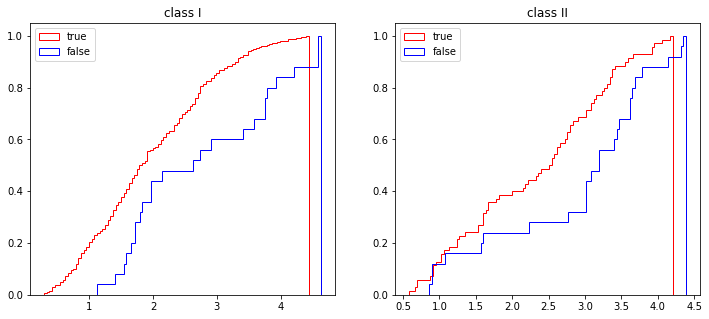

In [119]:
#netmhc Kd for true vs false register predictions
plt.figure(figsize=(12,5))
plt.subplot(121)
df=pmhcs_df_i
plt.hist(np.log10(df[df['netmhc_tails']==df['tails']]['netmhc_kd']),color='red',density=True,histtype='step',cumulative=1,bins=100)
plt.hist(np.log10(df[df['netmhc_tails']!=df['tails']]['netmhc_kd']),color='blue',density=True,histtype='step',cumulative=1,bins=100)
plt.legend(['true','false'],loc='upper left')
plt.title('class I')
plt.subplot(122)
df=pmhcs_df_ii
plt.hist(np.log10(df[df['netmhc_tails']==df['tails']]['netmhc_kd']),color='red',density=True,histtype='step',cumulative=1,bins=100)
plt.hist(np.log10(df[df['netmhc_tails']!=df['tails']]['netmhc_kd']),color='blue',density=True,histtype='step',cumulative=1,bins=100)
plt.legend(['true','false'],loc='upper left')
plt.title('class II')
plt.show()

# debug

In [50]:
pdb_source_dir=cwd+'/data/experimental_structures/pdb_source'

## debug, hetero, header

In [63]:
#pdb_id='6ulr'  #requires remark 350 processing
#pdb_id='1ao7' #full cl I complex
#pdb_id='5wxc'  #long cl I peps with holes
#pdb_id='2zsw' #has ABA in pep
#pdb_id='6p2f'  #hetero gap
#pdb_id='6p23'  #hetero gap
#pdb_id='6p27'  #hetero gap
#pdb_id='6p2s'  #hetero gap
#pdb_id='1es0'  #weird 13 pep gaps
#pdb_id='3ch1'
#pdb_id='6d7g'  #needs transform
#pdb_id='6uk2'  #needs transform, but none given
#pdb_id='2fyy'  #holes in the peptide
#pdb_id='3ln4'  #holes in the peptide, w. linker
#pdb_id='3ch1'   #pepX--X in one of the pep candidates
#pdb_id='6u3m'   #-1,1 in numbering
#pdb_id='3t0e'  #pep renumbering problem
#pdb_id='4qrr'   #error in renumbering
#pdb_id='6mfg'   #error in renumbering
#pdb_id='6mp1'   #error in renumbering
pdb_id='3omz'    #distance matrix error

input_file1=pdb_source_dir+f'/{pdb_id}.pdb'
output_dir1='./data/experimental_structures/processed_tmp'

structure,header=pdb_tools.parse_pdb(input_file1)

with open(input_file1) as f:
    pdb_lines=f.read().split('\n')
seqres={}
for line in pdb_lines:
    if line.startswith('SEQRES'):        
        chain=line[11]
        seqres.setdefault(chain,'')
        seq=line[19:].split()
        seq=''.join([pdb_tools.aa_dict.get(x) or 'X' for x in seq])            
        seqres[chain]+=seq

In [64]:
process_pdbs.process_structure(input_file1,output_dir1)

processing structure 3omz...


In [65]:
with open(output_dir1+f'/debug/{pdb_id}/errors.txt') as f:
    errors=f.read().split('\n')
proteins={}
for x in os.listdir(output_dir1+f'/proteins'):
    if x.startswith(pdb_id):
        i=int(x[:-5].split('_')[1])        
        with open(output_dir1+f'/proteins/'+x,'rb') as f:
            proteins[i]=pickle.load(f)
with open(output_dir1+f'/pdb_info/{pdb_id}.pckl','rb') as f:
    pdb_info=pickle.load(f)
print(errors)
print([x.keys() for x in proteins.values()])
print(pdb_info)

['TCR assembler: 2 of 8 TCR chains unpaired;']
[dict_keys(['A']), dict_keys(['A']), dict_keys(['A', 'B']), dict_keys(['A', 'B']), dict_keys(['A', 'B'])]
{'deposition_date': '2010-08-27', 'resolution': 3.04, 'includes_mhc': False, 'includes_tcr': True}


In [76]:
for x in proteins.values():
    if 'P' in x:
        print(x['P']['data']['seq'])
        print(x['P']['info'])

['g' 's' 'h' 's' 'r' 'g' 'Y' 'E' 'I' 'A' 'P' 'V' 'F' 'V' 'L' 'L' 'E' 'Y'
 'V' 'T' 'g' 's' 'g' 's' 'g' 's' 'g']
{'chain': 'P', 'gaps': array([],
      dtype=[('seq', '<U3'), ('num', '<i2'), ('ins', '<U1'), ('pdbnum', '<U5'), ('ss', '<U15'), ('mutations', '<U3')]), 'linker': [False, True], 'hetero': False, 'hetero_res': {}}


In [55]:
with open(output_dir1+f'/debug/{pdb_id}/aligned_fragments.pckl','rb') as f:
    fragments=pickle.load(f)
with open(output_dir1+f'/debug/{pdb_id}/pep_candidates.pckl','rb') as f:
    pep_candidates=pickle.load(f)
print(len(fragments))
print(len(pep_candidates))

8
0


In [61]:
for f in fragments:
    print(f[1].seq())

ssnlegrtkSVIRQTGSSAEITCDLaegstGYIHWYLHQEGKAPQRLLYYDSYTSSVVLESGISPGKYDTYGStrKNLRMILRNLIENDSGVYYCATWDQNYYKKLFGSGTSLVVT
aQKVTQAQSSVSMPVRKAVTLNCLYETSWWSYYIFWYKRLPSKEMIFLIRQGSDEQNAKSGRYSVNFKKAAKSVALTISALQLEDSAKYFCALGESLTRADKLIFGKGTRVTVEP
ssnlegrtkSVIRQTGSSAEITCDLaegstGYIHWYLHQEGKAPQRLLYYDSYTSSVVLESGISPGKYDTygstrkNLRMILRNLIENDSGVYYCATWDQNYYKKLFGSGTSLVVT
aQKVTQaqSSVSMPVRKAVTLNCLYETSWWSYYIFWYKRLPSKEMIFLIRQGSDEQNAKSGRYSVNFKKAAKSVALTISALQLEDSAKYFCALGESLTRADKLIFGKGTRVTVEP
ssnlegrtksvIRQTGSSAEITCDLaegstGYIHWYLHqegKAPQRLLYYDSYTSSVVLEsgisPGKYDTygstrkNLRMILRNLIENDSGVYYCATWDQNYYKKLFGSGTSLVVT
aQKVTQaqssVsmpvrkaVTLNCLYETSWWSYYIFWYKRLPSKEMIFLIRQGSDEQNAKSGRYSVNFKKaaKSVALTISalqledsaKYFCALGESLTRADKLIFGKgtrvtvep
ssnlegrtksVIrqtgSSAEITCDLAegstGYIHWYLHQEgkaPQRLLYYDSYTSSVVLESGIspgKYDTYgstrkNLRMILRnlIENDSGVYYCATWDQNYYKKLFGSGTSLVvt
aqkvtqaqssvsmpvrkavtlnclyetswwsYYIFWykrlpskemiflirqgsdeqnaksgrysvnfkkaaksvaltisalqledsakyfcALGESLTRADKLIFGkgtrvtvep


In [574]:
for p in pep_candidates:
    chain=p.info['chain']
    print(chain)
    print(p.seq())
    print(seqres.get(chain))

A
TAPDNLGKMGgggsggggsgggg
TAPDNLGKMGGGGSGGGGSGGGGSIQKTPQIQVYSRHPPENGKPNILNCYVTQFHPPHIEIQMLKNGKKIPKVEMSDMSFSKDWSFYILAHTEFTPTETDTYACRVKHASMAEPKTVYWDRDMGGGGSGGGGSGGGGSGGGGSGPHSMRYFETAVSRPGLEEPRYISVGYVDNKEFVRFDSDAENPRYEPRAPWMEQEGPEYWERETQKAKGQEQWFRVSLRNLLGAYNQSAGGSHTLQQMSGCDLGSDWRLLRGYLQFAYEGRDYIALNEDLKTWTAADMAAQITRRKWEQSGAAEHYKAYLEGECVEWLHRYLKNGNATLLRTDSPKAHVTHHPRSKGEVTLRCWALGFYPADITLTWQLNGEELTQDMELVETRPAGDGTFQKWASVVVPLGKEQNYTCRVYHEGLPEPLTLRWEPAAAGGGLNDIFEAQKIEWHEHHHHHHHH
A
ggggsggggsggggsgGGGS
TAPDNLGKMGGGGSGGGGSGGGGSIQKTPQIQVYSRHPPENGKPNILNCYVTQFHPPHIEIQMLKNGKKIPKVEMSDMSFSKDWSFYILAHTEFTPTETDTYACRVKHASMAEPKTVYWDRDMGGGGSGGGGSGGGGSGGGGSGPHSMRYFETAVSRPGLEEPRYISVGYVDNKEFVRFDSDAENPRYEPRAPWMEQEGPEYWERETQKAKGQEQWFRVSLRNLLGAYNQSAGGSHTLQQMSGCDLGSDWRLLRGYLQFAYEGRDYIALNEDLKTWTAADMAAQITRRKWEQSGAAEHYKAYLEGECVEWLHRYLKNGNATLLRTDSPKAHVTHHPRSKGEVTLRCWALGFYPADITLTWQLNGEELTQDMELVETRPAGDGTFQKWASVVVPLGKEQNYTCRVYHEGLPEPLTLRWEPAAAGGGLNDIFEAQKIEWHEHHHHHHHH
A
aaaggglndifeaqkiewhehhhhhhhh
TAPDNLGKMGGGGSGGGGSGGGGS

In [575]:
pep=pep_candidates[0]
seqres_seq=seqres[pep.info['chain']]
pep.data,seqres_seq,pep.info

(array([('T',  1, ' ', '   1 ', '', ''), ('A',  2, ' ', '   2 ', '', ''),
        ('P',  3, ' ', '   3 ', '', ''), ('D',  4, ' ', '   4 ', '', ''),
        ('N',  5, ' ', '   5 ', '', ''), ('L',  6, ' ', '   6 ', '', ''),
        ('G',  7, ' ', '   7 ', '', ''), ('K',  8, ' ', '   8 ', '', ''),
        ('M',  9, ' ', '   9 ', '', ''), ('G', 10, ' ', '  10 ', '', ''),
        ('g', 11, ' ', '  11 ', '', ''), ('g', 12, ' ', '  12 ', '', ''),
        ('g', 13, ' ', '  13 ', '', ''), ('s', 14, ' ', '  14 ', '', ''),
        ('g', 15, ' ', '  15 ', '', ''), ('g', 16, ' ', '  16 ', '', ''),
        ('g', 17, ' ', '  17 ', '', ''), ('g', 18, ' ', '  18 ', '', ''),
        ('s', 19, ' ', '  19 ', '', ''), ('g', 20, ' ', '  20 ', '', ''),
        ('g', 21, ' ', '  21 ', '', ''), ('g', 22, ' ', '  22 ', '', ''),
        ('g', 23, ' ', '  23 ', '', '')],
       dtype=[('seq', '<U3'), ('num', '<i2'), ('ins', '<U1'), ('pdbnum', '<U5'), ('ss', '<U15'), ('mutations', '<U3')]),
 'TAPDNLGKMGGGGSGGGGSGG

In [ ]:
#pymol matrix
#cmd.transform_selection('selection_name',[matrix_list],0,0,0,0)
#matrix: (first 3 rows as in BIOMT, last row 0,0,0,1)
#-0.5,-0.866025,0.,-61.9765,0.866025,-0.5,0.,107.34645,0.,0.,1.,-51.38533,0.,0.,0.,1.

In [310]:
#check hetero
mod_het={}
for x in results_list:
    with open(output_dir+f'/info/{x}/mod_het.pckl','rb') as f:
        mod_het[x]=pickle.load(f)
print('total loaded', len(mod_het))

#check for modified residues
for k,v in mod_het.items():
    if v['modified']:
        print(k,v['modified'])
#check for het groups
het_list=[]
for k,v in mod_het.items():
    if v['het']:
        het_list+=list(v['het'])
utils.print_hist(het_list,order=-1)        

total loaded 1350
2h26 {'UNK'}
4pgc {'UNK'}
GOL 304
NAG 268
SO4 160
EDO 132
 NA 101
FUC  81
ACT  54
 CL  51
BMA  46
MAN  38
PEG  32
CIR  28
PLM  26
PO4  23
 MG  22
 ZN  19
 CD  16
 CA  16
2LJ  15
MES  15
IOD  13
MPD  12
SEP  12
EPE  11
ACE  10
PG4  10
MSE   9
AGH   9
FUL   9
MLA   8
30W   8
ACY   8
ABA   8
 CO   7
CSO   6
CUY   6
PGE   6
URE   5
B3P   5
MRD   5
D12   5
CIS   5
FMT   5
NDG   4
3AZ   4
IMD   4
6UL   4
ALC   4
1KX   4
JLS   4
PRV   4
PRQ   4
GLY   3
GAL   3
EM4   3
FLC   3
  K   3
KFP   3
 BR   3
TRS   3
 NI   3
TAM   3
IPA   3
PBS   3
NO3   3
NH2   3
DMS   3
7LP   3
MLI   3
GSL   2
ELM   2
ELS   2
LEU   2
TWT   2
EMG   2
TIG   2
LGN   2
FEE   2
LSC   2
QUX   2
PRO   2
POV   2
HEX   2
MAA   2
GCY   2
GLC   2
P4G   2
SCN   2
PII   2
GIC   2
XY1   2
1O2   2
ARG   2
BAL   2
3TF   2
C8P   2
7LM   2
70E   2
CIT   2
6FP   2
42H   2
1VY   2
4GH   2
DB6   2
 CU   2
D3D   2
DB3   2
 MN   2
NBU   1
PC6   1
PCA   1
3NI   1
NLE   1
3GH   1
3GD   1
3GB   1
2L4   1
49X   1
PAM   1
P1J 

In [309]:
hetero_exclude=['GOL','NAG','SO4','EDO','NA','FUC','ACT','CL','BMA','MAN','PEG']

{'modified': None, 'het': {'EMC'}}

In [4]:
#Bio.PDB header keys
#{'name', 'deposition_date', 'structure_method', 'structure_reference', 'missing_residues', 
#'keywords', 'journal_reference', 'journal', 'compound', 'idcode', 'resolution', 'release_date', 
#'author', 'has_missing_residues', 'source', 'head'}

#so far, all have dates, almost all (except 1bwm) have resolutions

## blast thresholds

In [63]:
#choose thresholds
thresholds={'MHC_1_A':250,'B2M':300,'MHC_2_A':400,'MHC_2_B':400,
            'TCR_A_V':300,'TCR_B_V':300,'TCR_G_V':300,'TCR_D_V':300,'TCR_A/D_V':300}    

#no thresholds for TRJ, because TRJ identified in the realign step; TCR identified purely from TRV;
#(TRJ is too short)

In [59]:
hits_by_protein={}
for x in os.listdir(output_dir+'/debug'):
    with open(output_dir+'/debug/'+x+'/hits_prefiltered.pckl','rb') as f:
        hits=pickle.load(f)
        for x in hits:
            hits_by_protein.setdefault(x['protein'],[]).append(x)
print(hits_by_protein.keys())
print(hits[0].keys())

dict_keys(['B2M', 'MHC_1_A', 'TCR_A_V', 'TCR_B_V', 'TCR_G_V', 'MHC_2_A', 'MHC_2_B', 'TCR_D_V', 'TCR_A/D_V'])
dict_keys(['protein', 'species', 'locus', 'allele', 'len_target', 'score', 'identities', 'query_start', 'query_end'])


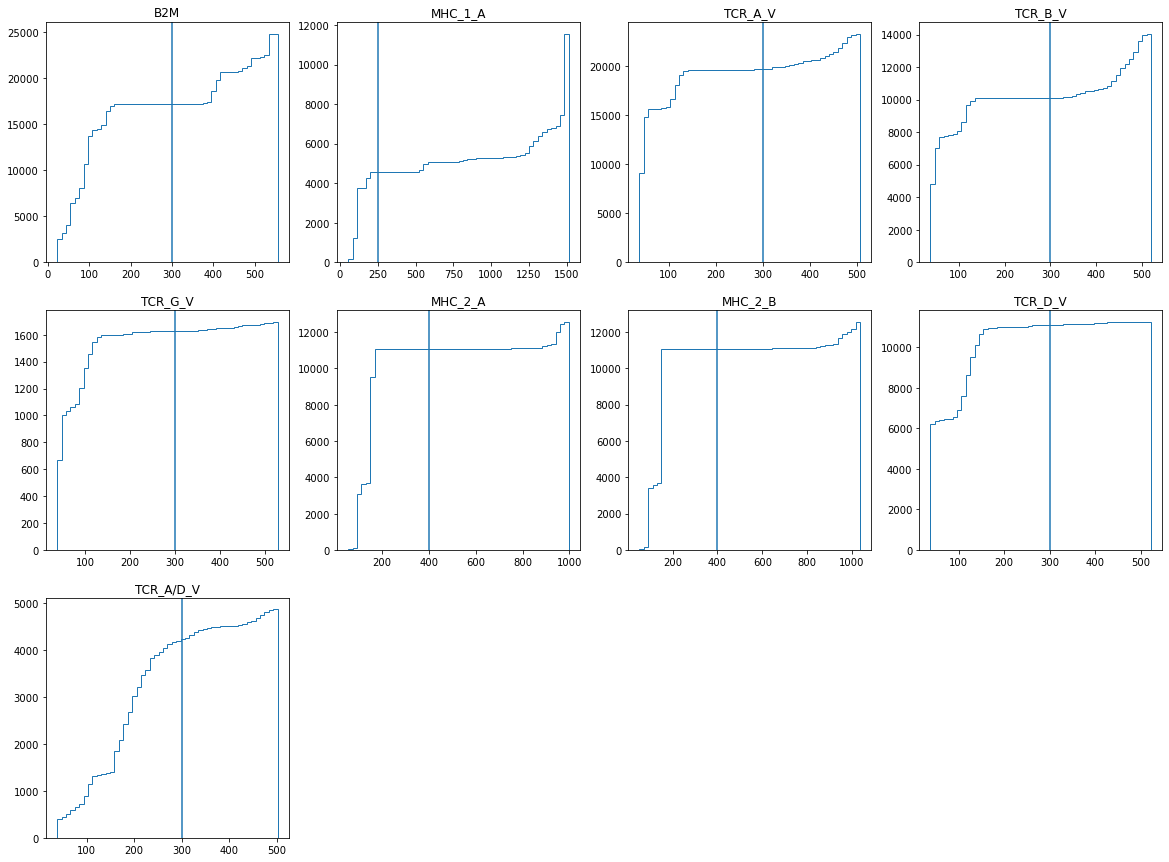

In [64]:
#plot score/match histograms

k='score' #'identities'

def f1(a,k):
    return [x[k] for x in a]
l=len(hits_by_protein)
nx=4
ny=l//3+int(l%3!=0)
plt.figure(figsize=(20,5*ny))
for i,xx in enumerate(hits_by_protein.items()):
    plt.subplot(ny,nx,i+1)
    plt.hist(f1(xx[1],k),bins=50,histtype='step',cumulative=1)
    plt.axvline(thresholds[xx[0]])
    plt.title(xx[0])
plt.show()

## choose ref structures, develop pep numbering

In [710]:
#load old pmhc data

import csv
import ast
def read_source(source):    
    source=ast.literal_eval(source)
    resolutions=[]
    pdbs=[]
    for a in source:        
        for x in a[1]:            
            resolutions.append(a[0])
            pdbs.append([x+y for y in a[1][x]])
    return pdbs,resolutions

old_dir='/data/vmikhayl/TCR_pMHC_prediction_2.1/data'

pmhcs_old=[]
with open(old_dir+'/experimental_structures/pmhcs.tsv') as f:
    f_tsv=csv.reader(f,delimiter='\t')
    print(next(f_tsv))
    for line in f_tsv:
        pmhcs_old.append(line)
print(len(pmhcs_old))    
for i,x in enumerate(pmhcs_old):
    pmhcs_old[i][-1]=read_source(x[-1])    
print(pmhcs_old[0])

['id', 'peptide', 'mhc species', 'mhc class', 'mhc_A allele', 'mhc_B allele', 'mhc_A mutations', 'mhc_B mutations', 'mhc_A seq', 'mhc_B seq', 'sources']
678
['0', 'SSIEFARL', 'mouse', 'I', 'H2-K*b', '', '', '', 'GPHSLRYFVTAVSRPGLGEPRYMEVGYVDDTEFVRFDSDAENPRYEPRARWMEQEGPEYWERETQKAKGNEQSFRVDLRTLLGYYNQSKGGSHTIQVISGCEVGSDGRLLRGYQQYAYDGCDYIALNEDLKTWTAADMAALITKHKWEQAGEAERLRAYLEGTCVEWLRRYLKNGNATLLRT', '', ([['1t0mPA___', '1t0mQD___'], ['1rk0PA___']], [2.0, 2.61])]


In [761]:
#sort by resolution
resolutions=[x[-1][1][0] for x in pmhcs_old]
ind=np.argsort(resolutions)
pmhcs_old=[pmhcs_old[i] for i in ind]
for x in pmhcs_old:
    pdbcode,res=x[-1][0][0],x[-1][1][0]
    if len(x[1])==12: #x[3]=='II':#pdbcode[0][-2:]!='__': # len(pdbcode[0][4:].replace('_',''))>=4:
        print(x[:8],pdbcode,res)  

#top by resolution among human structures for cl I and II

#pMHC-TCR
#I : 1oga
#['26', 'GILGFVFTL', 'human', 'I', 'HLA-A*02:01', '', '', ''] ['1ogaCA_DE'] 1.4
#II: 1j8h
#pep in 1j8h has many assays in IEDB, and pep in 4may has two (subpep, actually)
#in 4may, pep tethered to TCR; in 1j8h no linkers for anything
#['412', 'QLVHFVRDFAQL', 'human', 'II', 'HLA-DQA1*01:02', 'HLA-DQB1*05:01', '', ''] ['4mayDABCD'] 2.2
#['31', 'PKYVKQNTLKLAT', 'human', 'II', 'HLA-DRA*01:01', 'HLA-DRB1*04:01', '', ''] ['1j8hCABDE'] 2.4

#pMHC
#I : 3mre
#choose 3mre, because A*02:01 and famous peptide
#['122', 'GRFAAAIAK', 'human', 'I', 'HLA-B*27:09', '', '', ''] ['1k5nCA___'] 1.09
#['239', 'GLCTLVAML', 'human', 'I', 'HLA-A*02:01', '', '', ''] ['3mrePA___'] 1.1
#II: 5ni9
#choose 5ni9: many IEDB assays, no linker; (has partner structure 5nig with citrullinated pep)
#['539', 'KRIAKAVNEKSCNC', 'human', 'II', 'HLA-DRA*01:01', 'HLA-DRB1*04:01', '', ''] ['5ni9CAB__'] 1.33
#['463', 'VSKWRMATPLLMQAL', 'human', 'II', 'HLA-DRA*01:01', 'HLA-DRB1*01:01', '', ''] ['4x5wCAB__'] 1.34
#['336', 'SAVRLRSSVPGVR', 'human', 'II', 'HLA-DRA*01:01', 'HLA-DRB1*04:02', '', ''] ['4mdjCAB__'] 1.7

#TCR
# 1oga

['442', 'FVLELEPEWTVK', 'human', 'I', 'HLA-A*02:01', '', '', ''] ['5ddhCA___'] 1.5
['88', 'CPSQEPMSIYVY', 'human', 'I', 'HLA-B*35:08', '', '', ''] ['3bw9CA___'] 1.75
['483', 'TSTFEDVKILAF', 'human', 'I', 'HLA-B*57:01', '', '', ''] ['5t6yCA___'] 1.76
['84', 'KKVITAFNDGLK', 'mouse', 'II', 'H2-IEA*d', 'H2-IEB*k', '', ''] ['1fneBAB__', '1fneDCD__'] 1.9
['313', 'EECDSELEIKRY', 'human', 'I', 'HLA-B*44:03', '', '', ''] ['4jqxBA___'] 1.9
['60', 'KKVITAFNEGLK', 'mouse', 'II', 'H2-IEA*d', 'H2-IEB*k', '', ''] ['1fngBAB__', '1fngDCD__'] 1.9
['518', 'LVERLYLVCGEE', 'mouse', 'II', 'H2-IAA*d', 'H2-IAB*g7', 'N|  70 |C', ''] ['6blrBAB__'] 1.96
['492', 'MATPLLMQALPM', 'human', 'II', 'HLA-DQA1*05:01', 'HLA-DQB1*02:01', '', ''] ['5ksvCAB__'] 2.19
['412', 'QLVHFVRDFAQL', 'human', 'II', 'HLA-DQA1*01:02', 'HLA-DQB1*05:01', '', ''] ['4mayDABCD'] 2.2
['83', 'SRGGASQYRPSQ', 'mouse', 'II', 'H2-IAA*u', 'H2-IAB*u', '', ''] ['1k2dPAB__'] 2.2
['74', 'AWRSDEALPLGS', 'human', 'II', 'HLA-DRA*01:01', 'HLA-DRB3*01:01', '

In [746]:
#develop numbering
#cl II, cl I, corresp between cl I and II

#cl II numbering template 4x5w:
#  V  S  K  WRMATPLLM Q  A  L
# 07 08 09  123456789 91 92 93
#   

#['539', 'KRIAKAVNEKSCNC', 'human', 'II', 'HLA-DRA*01:01', 'HLA-DRB1*04:01', '', ''] ['5ni9CAB__'] 1.33
# pymol identifies disulfide between C(N)C!!
#  KRIAKAVNEKS CNC
#  --a-aa-Aa-a ---
#    123456789
#core: 3-11

#['463', 'VSKWRMATPLLMQAL', 'human', 'II', 'HLA-DRA*01:01', 'HLA-DRB1*01:01', '', ''] ['4x5wCAB__'] 1.34
#V SKWRMATPLLM QAL
#- --Aaa---a-A -00
#    123456789
#core: 4-12

#['373', 'AYDGKDYIALK', 'human', 'II', 'HLA-DPA1*01:03', 'HLA-DPB1*02:01', '', ''] ['4p5mBAB__', '4p5mDCD__', '4p5mFEF__', '4p5mHGH__'] 1.7
# AYDGKDYIALK
# -Aa-a-AA-a-
#  123456789

#pymol: 11 res align well!
#   KRIAKAVNEKS CNC
# V SKWRMATPLLM QAL

## VSKWRMATPLLM QAL
#    AYDGKDYIAL K
#     123456789      ? (M and L at the end are looking down: anchors!)

#compare to cl I
#['239', 'GLCTLVAML', 'human', 'I', 'HLA-A*02:01', '', '', ''] ['3mrePA___'] 1.1

#   123 456789
#VSKWRM ATPLLM QAL
#    GLCTLVAML
#    123456789
#     x    xxx     #where good agreement

#cl I 8 vs 9
#['89', 'FPTKDVAL', 'human', 'I', 'HLA-B*35:08', '', '', ''] ['3bwaCA___'] 1.3
#  FPT KD  VAL
#  GLC TLV AML
#  XXX     xXX
#  123 456 789

#cl I unusual mode: res1 in standard notation missing, behaving like 10-mer with gap at 1
#2gtw

#   234 556 789
#   LAG IGI LTV
#  GLCT L V AML
#   XXx     xXX
#  1234 5 6 789
#

# 9 A2 vs 8 B8
#['537', 'RAKFKQLL', 'human', 'I', 'HLA-B*08:01', '', '', ''] ['3spvCA___'] 1.3
#       A       #(anchor:5.3)=>delete pos 6 comp. to FLRGRAYGL
#  RAKF K  QLL
#  GLCT LV AML
#  XXXx    XXX
#  1234 56 789

# 9 A2 vs 9 B8
#['48', 'FLRGRAYGL', 'human', 'I', 'HLA-B*08:01', '', '', ''] ['1mi5CA_DE'] 2.5
#       A      #(anchor:5.4)
#  FLRG RA YGL
#  GLCT LV AML
#  XXx   x xXX

#10 A2 vs 9 A2
#['644', 'AVYDGREHTV', 'human', 'I', 'HLA-A*02:01', '', '', ''] ['6trnCA___'] 1.35
# AVYD GR EHTV
# GLCT L  VAML
# XXx      xXX
# 1234 5  6789
# GR kinda arcs around L. Let's do 5.1 insertion

#11 A2 vs 9 A2
#['443', 'FVLELEPEWTV', 'human', 'I', 'HLA-A*02:01', '', '', ''] ['5d9sCA___'] 1.87
#  FVLELEPEWTV
#  GLCTL V AML
#  XXXx    xXX
#  12345 6 789
#insertions 5.1 6.9

#conclusion for cl I binding core numbering:
#8  12345 789
#9  123456789
#10 12345 5.1 6789
#11 12345 5.1 5.2 6789
#...

#NOTE: for cl I when no templ of same core len and same MHC available, would be beneficial
#to choose same MHC, difft core len template, and do different core alignments!
#(usefulness will depend on how far MHC in nearest matching core len template)

In [776]:
def get_pep_coords(s_d):
    resnums,coords=[],[]
    for k,v in s_d.items():
        resnums.append(k)
        coords.append(v['CA'])
    return np.array(resnums),np.array(coords)

In [782]:
#pdb_id='3bwaCA___' #cl I B35 len 8
pdb_id='5d9sCA___' #cl I A2 len 11
filename=f'/data/vmikhayl/TCR_pMHC_prediction_2.1/data/experimental_structures/pdb_cleaned/{pdb_id}.pdb'
structure,_=pdb_tools.parse_pdb(filename)

ref_filename='./data/experimental_structures/ref_structures/3mrePA___.pdb' #cl I
#ref_filename='./data/experimental_structures/ref_structures/4x5wCAB__.pdb' #cl II
ref_structure,_=pdb_tools.parse_pdb(ref_filename)

#superimpose on mhc
pdb_tools.superimpose_by_chainmap(structure,ref_structure,[['M','M'],['N','N']])
print(pdb_tools.rmsd_by_chainmap(structure,ref_structure,[['P','P']])) #unaligned resmap

#get coords
pep_resnum,pep_coord=get_pep_coords(pdb_tools.get_structure_dict(structure,True)['P'])
ref_pep_resnum,ref_pep_coord=get_pep_coords(pdb_tools.get_structure_dict(ref_structure,True)['P'])

d2matrix=pdb_tools.distance2_matrix(pep_coord,ref_pep_coord)
closest_refs=[]
ds=[]
for i in range(len(pep_resnum)):
    i0=np.argmin(d2matrix[i,:])
    ds.append(d2matrix[i,i0]**0.5)
    closest_refs.append(ref_pep_resnum[i0])
for x,y in zip(closest_refs,ds):
    print(x,y)

superimposing on 182 atoms...
{'CA': 3.547954647079691, 'all': 4.688564332292655}
   1  0.2284090331483817
   2  0.3941478944075933
   3  0.6389571553076286
   4  0.3068095914042699
   5  2.4626001947612775
   6  1.9247155016438315
   6  3.7400734809551985
   7  4.629335381941042
   7  1.1586263825649796
   8  0.8318594455196261
   9  0.7797037080903364


In [ ]:
#left :...,5
#insert:5.1
#       5.1 5.9
#       5.1 5.2 5.9
#...
#right: 6,... 

## analyze pmhc contacts

In [405]:
#pdb_id='1fngBAB__' #II
#pdb_id='1s7vCA___'
#pdb_id='1s7rCA___' 
#pdb_id='1ogaCA_DE'

#secondary anchor jumping
#pdb_id='3mrcPA___' #sa 5
pdb_id='3mr9PA___' #sa 6

filename=f'/data/vmikhayl/TCR_pMHC_prediction_2.1/data/experimental_structures/pdb_cleaned/{pdb_id}.pdb'
structure,header=pdb_tools.parse_pdb(filename)
atoms_mhc=[]
for c in structure.get_chains():
    if c.id in ['M','N']:
        atoms_mhc+=list(c.get_atoms())
    elif c.id=='P':
        atoms_pep=list(c.get_atoms())
print('mhc atoms:',len(atoms_mhc))
print('pep atoms:',len(atoms_pep))

contact_counts=pdb_tools.count_r_by_r_contacts(atoms_pep,atoms_mhc,eps=0.1)
pep_r_u=np.unique([x[0] for x in contact_counts])
for x in pep_r_u:
    for k,v in contact_counts.items():
        if k[0]==x:
            print(k,v)
    print()

mhc atoms: 2895
pep atoms: 132
('P   1 ', 'M   5 ') 3
('P   1 ', 'M   7 ') 6
('P   1 ', 'M  59 ') 1
('P   1 ', 'M  63 ') 3
('P   1 ', 'M  66 ') 4
('P   1 ', 'M1070 ') 6
('P   1 ', 'M1077 ') 15
('P   1 ', 'M1081 ') 7

('P   2 ', 'M   7 ') 6
('P   2 ', 'M   9 ') 6
('P   2 ', 'M  45 ') 6
('P   2 ', 'M  63 ') 6
('P   2 ', 'M  66 ') 10
('P   2 ', 'M  67 ') 5
('P   2 ', 'M  70 ') 1
('P   2 ', 'M1009 ') 7
('P   2 ', 'M1070 ') 1

('P   3 ', 'M  66 ') 1
('P   3 ', 'M  70 ') 8
('P   3 ', 'M1009 ') 11
('P   3 ', 'M1067 ') 3
('P   3 ', 'M1070 ') 6

('P   4 ', 'M  66 ') 2
('P   4 ', 'M1070 ') 2

('P   6 ', 'M  70 ') 11
('P   6 ', 'M  73 ') 11
('P   6 ', 'M1007 ') 7

('P   7 ', 'M  73 ') 2
('P   7 ', 'M1059 ') 2

('P   8 ', 'M  73 ') 4
('P   8 ', 'M  76 ') 2
('P   8 ', 'M  77 ') 5
('P   8 ', 'M1058 ') 7
('P   8 ', 'M1059 ') 3

('P   9 ', 'M  77 ') 8
('P   9 ', 'M  81 ') 5
('P   9 ', 'M  84 ') 4
('P   9 ', 'M1026 ') 3
('P   9 ', 'M1033 ') 3
('P   9 ', 'M1055 ') 9
('P   9 ', 'M1058 ') 2
('P   9 ', 'M1

In [417]:
#load old pmhc data

import csv
import ast
def read_source(source):    
    source=ast.literal_eval(source)
    resolutions=[]
    pdbs=[]
    for a in source:        
        for x in a[1]:            
            resolutions.append(a[0])
            pdbs.append([x+y for y in a[1][x]])
    return pdbs,resolutions

old_dir='/data/vmikhayl/TCR_pMHC_prediction_2.1/data'

pmhcs_old=[]
with open(old_dir+'/experimental_structures/pmhcs.tsv') as f:
    f_tsv=csv.reader(f,delimiter='\t')
    print(next(f_tsv))
    for line in f_tsv:
        pmhcs_old.append(line)
print(len(pmhcs_old))    
for i,x in enumerate(pmhcs_old):
    pmhcs_old[i][-1]=read_source(x[-1])    
print(pmhcs_old[0])

['id', 'peptide', 'mhc species', 'mhc class', 'mhc_A allele', 'mhc_B allele', 'mhc_A mutations', 'mhc_B mutations', 'mhc_A seq', 'mhc_B seq', 'sources']
678
['0', 'SSIEFARL', 'mouse', 'I', 'H2-K*b', '', '', '', 'GPHSLRYFVTAVSRPGLGEPRYMEVGYVDDTEFVRFDSDAENPRYEPRARWMEQEGPEYWERETQKAKGNEQSFRVDLRTLLGYYNQSKGGSHTIQVISGCEVGSDGRLLRGYQQYAYDGCDYIALNEDLKTWTAADMAALITKHKWEQAGEAERLRAYLEGTCVEWLRRYLKNGNATLLRT', '', ([['1t0mPA___', '1t0mQD___'], ['1rk0PA___']], [2.0, 2.61])]


In [419]:
#compute contact maps
t0=time.time()
for i,x in enumerate(pmhcs_old):
    c_id=x[0]
    pdb_id=x[-1][0][0][0]
    filename=f'/data/vmikhayl/TCR_pMHC_prediction_2.1/data/experimental_structures/pdb_cleaned/{pdb_id}.pdb'
    structure,header=pdb_tools.parse_pdb(filename)
    atoms_mhc=[]
    for c in structure.get_chains():
        if c.id in ['M','N']:
            atoms_mhc+=list(c.get_atoms())
        elif c.id=='P':
            atoms_pep=list(c.get_atoms())
    contact_counts=pdb_tools.count_r_by_r_contacts(atoms_pep,atoms_mhc,eps=0.1)
    with open(f'./data/experimental_structures/contact_maps_old/{c_id}.pckl','wb') as f:
        pickle.dump(contact_counts,f)
    if i%50==0:
        print(i)
print('completed in {:5.1f} s'.format(time.time()-t0))        

0
50
100
150
200
250
300
350
400
450
500
550
600
650
completed in 767.1 s


In [438]:
#plot contact numbers for cl II
cnums=[]
for x in pmhcs_old:
    if x[3]=='II':
        c_id=x[0]
        with open(f'./data/experimental_structures/contact_maps_old/{c_id}.pckl','rb') as f:
            c_map=pickle.load(f)
        pepnums=np.sort(np.unique([k[0] for k in c_map]))
        cnum=np.zeros(len(pepnums))
        for k in c_map:
            cnum[pepnums==k[0]]+=c_map[k]
        cnums.append(np.array(cnum))

In [439]:
len(cnums)

108

In [461]:
def optimal_shift(x,y):
    '''
    find optimal shift of x relative to y for two arrays of numbers x and y;
    (optimal by squared distance; ends imputed with zeros)
    '''
    d2=[]
    shifts=list(range(-len(x)+1,len(y)))
    for i in shifts:
        x_l=x[:max(0,-i)]
        x_c=x[max(0,-i):max(0,len(y)-i)]
        x_r=x[max(0,len(y)-i):]
        y_l=y[:max(0,i)]
        y_c=y[max(0,i):max(0,i+len(x))]
        y_r=y[max(0,i+len(x)):]          
        d=0
        d+=np.sum(x_l**2)
        d+=np.sum(x_r**2)
        d+=np.sum(y_l**2)
        d+=np.sum(y_r**2)
        d+=np.sum((x_c-y_c)**2)        
        d2.append(d)         
    imin=np.argmin(d2)
    return shifts[imin]

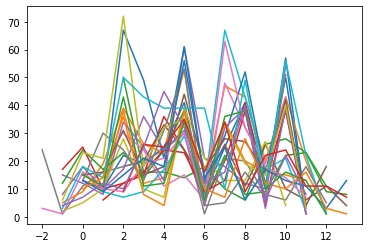

In [466]:
inds=np.random.permutation(len(cnums))[:25]
plt.figure()
for i in inds:
    i0=optimal_shift(cnums[i],cnums[0])
    xx=np.arange(i0,i0+len(cnums[i]))
    plt.plot(xx,cnums[i])
plt.show()

In [742]:
#load



c_id='373'#'539' #'463' 
with open(f'./data/experimental_structures/contact_maps_old/{c_id}.pckl','rb') as f:
    cc=pickle.load(f)
    
#CHANGE INS codes from 9..1 to 1..9 in cdr, mhc and pep!!! so that sorting pdbnums works    

In [743]:
cdict={}
for k in cc:
    kk=int(k[0][1:])
    cdict.setdefault(kk,0)
    cdict[kk]+=cc[k]
print(cdict)



{1: 14, 2: 34, 3: 22, 4: 5, 5: 29, 6: 7, 7: 34, 8: 33, 9: 9, 10: 19, 11: 9}


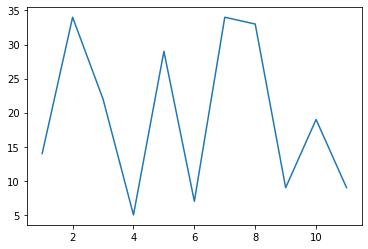

In [744]:
plt.figure()
plt.plot(cdict.keys(),cdict.values())
plt.show()

## structure superimpose and rmsd

In [628]:
#pdb_ids=['1s7tCA___','1s7qCA___' ]   #same cluster
#pdb_ids=['1s7vCA___','1s7rCA___' ]  #different clusters
pdb_ids=['1s7vCA___','1uvqCAB__']    #cl I vs cl II
structures=[]
for pdb_id in pdb_ids:
    filename=f'/data/vmikhayl/TCR_pMHC_prediction_2.1/data/experimental_structures/pdb_cleaned/{pdb_id}.pdb'
    structure,header=pdb_tools.parse_pdb(filename)
    structures.append(structure)

In [629]:
#chainmap=[['M','M'],['M','N'],['P','P']]
chainmap=[['M','M'],['M','N']]
#chainmap=[['P','P']]
pdb_tools.superimpose_by_chainmap(*structures,chainmap,CA_only=True,verbose=False)

superimposing on 169 atoms...


2.965437872899223

In [630]:
chainmap=[['P','P']]
pdb_tools.rmsd_by_chainmap(*structures,chainmap,verbose=True)

res {'  11 ', '  12 ', '  10 ', '  13 '} present in structure 2 chain P but missing in structure 1 chain P;
rmsd over 9 residues...
rmsd_CA over 9 atoms...
rmsd_all over 88 atoms...


{'CA': 8.681307335067595, 'all': 8.855501919462581}

# trash

In [8]:
#cl II peps to compare cores to netmhciipan

for x in pmhcs.values():
    if x['class']=='II':
        pep=seq_tools.load_NUMSEQ(x['P'])
        mA=x['M']['info']
        mB=x['N']['info']
        print(x['pdbs'])
        print(mA['locus'],mA['allele'])
        print(mB['locus'],mB['allele'])
        print(pep.seq())
        print(pep.data['pdbnum'])
        print()

[('6biy_0', {'pep_gaps': 0, 'linker': False, 'resolution': 2.05, 'includes_tcr': 0})]
DRA 01:01
DRB1 04:04
DIFERIASEASRL
['   08' '   09' '   1 ' '   2 ' '   3 ' '   4 ' '   5 ' '   6 ' '   7 '
 '   8 ' '   9 ' '  10 ' '  11 ']

[('2q6w_1', {'pep_gaps': 0, 'linker': False, 'resolution': 2.25, 'includes_tcr': 0}), ('2q6w_0', {'pep_gaps': 1, 'linker': False, 'resolution': 2.25, 'includes_tcr': 0})]
DRA 01:01
DRB3 01:01
AWRSDEALPLGS
['   09' '   1 ' '   2 ' '   3 ' '   4 ' '   5 ' '   6 ' '   7 ' '   8 '
 '   9 ' '  10 ' '  11 ']

[('1ymm_0', {'pep_gaps': 9, 'linker': False, 'resolution': 3.5, 'includes_tcr': 2})]
DRA 01:01
DRB1 15:01
ENPVVHFFKNIVTPRGGSGGGGG
['   06' '   07' '   08' '   09' '   1 ' '   2 ' '   3 ' '   4 ' '   5 '
 '   6 ' '   7 ' '   8 ' '   9 ' '  10 ' '  11 ' '  12 ' '  13 ' '  14 '
 '  15 ' '  16 ' '  17 ' '  18 ' '  19 ']

[('1lnu_0', {'pep_gaps': 0, 'linker': True, 'resolution': 2.5, 'includes_tcr': 0}), ('1lnu_1', {'pep_gaps': 0, 'linker': True, 'resolution': 2.5, '

In [ ]:
#netmhcIIpan outputs (with true core indicated by spaces)
#    MHC              Peptide       Of        Core  Core_Rel        Identity      Score_EL %Rank_EL Exp_Bind 
#DRB1_0404        DI FERIASEAS RL    2   FERIASEAS     1.000        Sequence      0.458160     3.14       NA    
#DRB3_0101         A WRSDEALPL GS    1   WRSDEALPL     1.000        Sequence      0.773778     0.25       NA   
#DRB1_1501      ENPV VHFFKNIVT PR    4   VHFFKNIVT     1.000        Sequence      0.983438     0.02       NA   
#HLA-DQA10501-DQB10201  PVSK MRMATPLLM QA    4   MRMATPLLM     0.960        Sequence      0.561136     0.48       NA      0.480386        276.47     1.58   <=SB
#DRB1_0401(true 04:274)   WNRQ LYPEWTEAQ RLD    4   LYPEWTEAQ     1.000        Sequence      0.565103     1.62       NA 
#HLA-DPA10103-DPB10201 QA FWIDLFETI GGGSLVPRGS    2   FWIDLFETI     0.640        Sequence      0.007562    50.76
#HLA-DQA10201-DQB10202  A PFSEQEQPV LG    1   PFSEQEQPV     0.960        Sequence      0.287850     4.26  
#HLA-DQA10301-DQB10302(low q!) APSG EGSFQPSQE NPQGS    4   EGSFQPSQE     0.480        Sequence      0.004195    18.73
#4gbx_0 DRB1_0101  GKQNCLKL AT    1   KQNCLKLAT (wrong! but true core starts at pos 2; identifies as non-binder; with cut input, says pep should be >=9, i.e. can't work with core 8)   0.733        Sequence      0.000009    95.00  
#DRB1_0401(true 04:274)  KR IAKAVNEKS CNCL    2   IAKAVNEKS     1.000        Sequence      0.157800     8.53 
#5v4n_0,5v4n_1 (res 3.41!) DRB1_0101 G WISLWKGFS FGSGGSIEGR    8   FSFGSGGSI (wrong! decided to bind linker)  0.953        Sequence      0.030840    18.76
#DRB1_0101 G WISLWKGFS FGS(prev. cut)  2  ISLWKGFSF (also wrong!)    0.773        Sequence      0.011147    30.46 

In [ ]:
#prepare jobs to compute pairwise distances (used only for illustration)

#output_dir_tmp=f'/scratch/vmikhayl/tmp_pmhc_{atom}_distances/distances'   
output_dir_tmp=f'/scratch/lustre/vmikhayl/tmp_pmhc_{atom}_distances/distances'  #typhon

input_dir=f'/scratch/vmikhayl/tmp_pmhc_{atom}_distances'           
#input_dir_server=input_dir                                        #helios
input_dir_server=f'/scratch/lustre/vmikhayl/tmp_pmhc_{atom}_distances' 

inputs=list(itertools.combinations(pep_coords.keys(),2))

n_tasks=200 #112#56     #our cluster: 64 nodes * 28 cores
max_run_time=100    #in minutes
qos='short' #medium 
local=False #CHECK!
slow_nodes=[]

sh_path=f'./pmhcs_{atom}_distances.sh'
python_path='./template_tools.py'
argstring=f'geomdistances_{atom} {output_dir_tmp}'

n_tasks=utils.make_task(inputs,n_tasks,sh_path,python_path,input_dir,input_dir_server=input_dir_server,
                        qos=qos,max_run_time=max_run_time,slow_nodes=slow_nodes,local=local,argstring=argstring)
print('n tasks:',n_tasks)

In [ ]:
#assemble results
distances_all={}
for x in os.listdir(output_dir_tmp):
    with open(output_dir_tmp+f'/{x}','rb') as f:
        distances_all.update(pickle.load(f))
print(len(distances_all))   
l=len(pep_coords)
print(l*(l-1)/2)
#reduce to pmhcs
distances={}
for i,p in enumerate(pmhcs):
    for j,q in enumerate(pmhcs[i+1:]):
        d=distances_all.get((p['pdbs'][0][0],q['pdbs'][0][0])) or distances_all.get((q['pdbs'][0][0],p['pdbs'][0][0]))
        if d is None:
            raise ValueError(f'{i} {j}')
        distances[i,i+1+j]=d
distances_all=None #drop     
#note: cl I and cl II were aligned to different templates, hence I-II distances have no meaning!

dist_matrix=np.zeros((len(pmhcs),len(pmhcs))) #symmetric distance matrix
for i in range(len(pmhcs)):
    for j in range(len(pmhcs)):
        dist_matrix[i,j]=distances.get((i,j)) or distances.get((j,i)) or 0 

In [ ]:
#what resnames are present
symbols=[]
for i,x in enumerate(pep_coords_reduced):
    resnames=[r for r in x.keys() if r>='   1 ' and r<='   9 ']
    symbols.append('|'.join(resnames).replace(' ',''))
    #if '   1 ' not in resnames:
    #    print(i)
utils.print_hist(symbols)

In [3]:
output_dir='./data/experimental_structures/processed'
with open(output_dir+'/pmhcs.pckl','rb') as f:
    pmhcs=pickle.load(f)

In [7]:
pepmaps={}
for x in os.listdir(output_dir+'/debug'):
    if 'peptide_maps.pckl' in os.listdir(output_dir+f'/debug/{x}'):
        with open(output_dir+f'/debug/{x}/peptide_maps.pckl','rb') as f:
            pepmaps[x]=pickle.load(f)
print(len(pepmaps))

1011


In [11]:
pepmaps_II={k:v for k,v in pepmaps.items() if v[0][0]=='II'}
print(len(pepmaps_II))

171


In [15]:
reduced={k:'|'.join(v[0][1]) for k,v in pepmaps_II.items()}
print(len(reduced))

171


In [18]:
xx=np.unique(list(reduced.values()))
print(len(xx))

97


In [22]:
for a in xx:
    b=a.replace(' ','')
    if '1|2|3|4|5|6|7|8|9' not in b:
        print(b)

07|08|09|1|2|3|4|5|6|7|-----|-----|-----
09|1|2|3|4|5|6|7|7
09|1|2|3|4|6
09|1|2|3|4|6|7|8
2|3|4|5|6|7|8|9|10|10
10|9|8|7|6|5|4|3|2|1|09|08|07|07|07
-----|10|9|8|7|6|5|4|3|2|1|09|08|07|07|07


In [23]:
for k,v in reduced.items():
    b=v.replace(' ','')
    if '1|2|3|4|5|6|7|8|9' not in b:
        print(k,b)
        
#conclusion: only 4gbx and 1d5z look like non-conventional binding mode,
#but 4gbx is a part of a paper on DM -- can be transitory state...
#Looks like non-conventional modes for cl II are rare and can be ignored.

1d5m 09|1|2|3|4|5|6|7|7
1d6e 09|1|2|3|4|5|6|7|7
4aen -----|10|9|8|7|6|5|4|3|2|1|09|08|07|07|07
4gbx 2|3|4|5|6|7|8|9|10|10
3pgc 10|9|8|7|6|5|4|3|2|1|09|08|07|07|07
1hqr 07|08|09|1|2|3|4|5|6|7|-----|-----|-----
1d5z 09|1|2|3|4|6|7|8
1d5x 09|1|2|3|4|6


In [26]:
for x in pmhcs:
    pdbs=[a[0] for a in x['pdbs']]
    if '4gbx' in pdbs:
        print('yes')

In [30]:
for x in pmhcs:
    if 'N' in x and x['N']['info']['locus'] in ['DRB3','DRB5']:
        print(x['id'])
        print(x['N']['info']['locus']+'*'+x['N']['info']['allele'])
        print(''.join(x['P']['data']['seq']))
        print('|'.join(x['P']['data']['pdbnum']))
        print([a[0] for a in x['pdbs']])
        print()

61
DRB3*01:01
AWRSDEALPLGS
   09|   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |  10 |  11 
['2q6w_1', '2q6w_0']

311
DRB3*03:01
QVIILNHPGQISA
   08|   09|   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |  10 |  11 
['3c5j_0']

390
DRB5*01:01
VHFFKNIVTPRTPGG
   07|   08|   09|   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |  10 |  11 |  12 
['1zgl_1', '1zgl_0', '1zgl_3', '1zgl_2']

510
DRB5*01:01
GGVYHFVKKHVHES
   07|   08|   09|   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |  10 |  11 
['1h15_0', '1h15_1']

576
DRB3*03:01
QHIRCNIPKRISA
   08|   09|   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |  10 |  11 
['4h1l_0', '4h1l_1']

639
DRB5*01:01
NPVVHFFKNIVTPRTPPPSQ
   04|   05|   06|   07|   08|   09|   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |  10 |  11 |  12 |  13 |  14 
['1fv1_0', '1fv1_1']



In [32]:
for k in ['2q6w','3c5j','1zgl','1h15','4h1l','1fv1']:
    print(k,reduced[k[:4]])
#1h15 checked in pymol: normal

2q6w    09|   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |  10 |-----
3c5j    08|   09|   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |  10 |  11 
1zgl    08|   08|   09|   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |  10 |  12 |-----
1h15    08|   08|   09|   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |  11 |  12 
4h1l    08|   09|   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |  10 |  11 
1fv1    07|   07|   07|   07|   08|   09|   1 |   2 |   3 |   4 |   5 |   6 |   7 |   8 |   9 |  10 |  11 |  12 |  12 |  12 


In [17]:
[1,2,3].index(2)

1

In [18]:
38/50*8418/60

106.628

In [69]:
P=21.1*101325/760
mu=28e-3
R=8.31
T=273+23
rho=P*mu/(R*T)
0.2*rho

0.006404434193836625

In [109]:
for N in range(12,50):
    print(N,1-0.05**(1/(N+1)))

12 0.20581666518655073
13 0.19263617565013536
14 0.18103627252208465
15 0.17074972298248092
16 0.16156611126074016
17 0.1533175539572782
18 0.14586850331224344
19 0.13910834066826516
20 0.13294591102652342
21 0.12730543165483876
22 0.12212338890652308
23 0.11734615615494881
24 0.11292814500684323
25 0.10883035576078481
26 0.10501923017634429
27 0.10146573557272476
28 0.0981446276772957
29 0.09503385285530419
30 0.09211405994732369
31 0.0893681989862648
32 0.08678118929147494
33 0.08433964335062538
34 0.0820316358566705
35 0.07984650951989436
36 0.07777471100513789
37 0.07580765168296455
38 0.07393758892668656
39 0.0721575245055146
40 0.07046111727016413
41 0.06884260784039486
42 0.06729675341386787
43 0.06581877114493395
44 0.06440428880778348
45 0.06304930167405454
46 0.06175013471082447
47 0.06050340934889431
48 0.059306014189697054
49 0.058155079116972264
